# Table Of Contents

### 1) Introduction

### 2) Business Problem

### 3) Data Understanding 

### 4) Data Exploration and Analysis

### 5) Classification Modeling
   - 5a Modeling with Differenced Data
   - 5b Modeling with Seasonally Decomposed Residuals
   - 5c Modeling weekly trends
   
### 6) Time series modeling and forecasting

### 7) Further Considerations with species analysis

### 8) Conclusion

### 9) References

### 10) Appendix

----

# *Houston, We Have an Allergy Problem:*
## Pollen Count Predictions for Allergies in Houston, Tx
### Nicholas Kennedy May, 2022
![pollen spores](images/Misc_pollen_colorized_wikipedia.jpg)

# 1) Introduction and Business Understanding 
Allergies are a impact lives  everywhere, but esepcially in Texas, US. Central texas is notorious for severe allergies, but in reality this problem affects the whole state. The surprising thing about this is that most of texas is a desert without much flora to speak of. Houston, however is uniquly positioned in texas being relatively near the desert, the ocean, marshland and forest. 

Allergy seasons occur with consistent regularity throughout the year. Spring and fall are universally known as the worst times of the year for allergies due to high pollen counts. It therefore stands to reason that using basic climate data, like wind speed, temperature and precipitation, seasonal in nature themselves, could be used to estimate and forecast pollen counts

Yet, while very possible, using weather and climate data to predict pollen counts is not particularly ground-breaking, because this data is also subject seasonal fluctuation. However, if seasonality is removed from the equation, does information such as local precipitation, temperature and wind speed still have an effect? 

# 2) Business Problem
The past 2 years, ravaged by the Covid-19 global pandemic, has made much of the world wary of the tiniest sniffle for fear they have contracted the highly infectious disease that has killed so many. Additionally the broad variety and severity of symptoms across the board has had many confuse their sympotons with allergies and vice versa, thus bringing a much greater attention to Allergies in general. 

Knowing when healthcare systems can expect more patient visits due to allergies can help brace not only providers for the impact of higher case-loads, but also pharmacies for medicine stocking. With the National Allergy Bureau and the CDC working with medical providers and pharmacies, these organizations can not only prepare these kinds of entities, but also help bring awareness and understanding to individual allergy-sufferers among the general population. 

Lastly, in the further considerations a collaberation between public health organizations, pharmacies and members of the public is proposed in order to develop an application that can compare allergy medication purchases with species specific pollen data to use as a diagnostic support tool in identifying people's individual allergens.

<img src = "images/oak_cbs_austin.jpg">

# 3) Data Understanding and Preparation

The data used in this report comes from two sources: 
- Pollen data comes from The <a href="https://www.houstontx.gov/health/Pollen-Mold/pollen-archives.html">Houston Health Department website</a>
- Climate data comes from the the <a href="ncei.noaa.gov"> National Oceanic and Atmospheric Administration's (NOAA) National Center for Environmental Information (NCEI) </a>

Pollen Data was compiled from individual monthly spreadsheets from 2013 to 2022 consisting of pollen counts measured in parts per cubic meter. It consists of species specific daily pollen counts collected throughout the month except on weekends and holidays. It also distinguishes between tree, grass and weed pollen. The data was collected by three different technicians. 

Climate data was obtained for three testing sites, 2 located in Houston (suffixed '18' and '60'), and one located in Shreveport, LA (suffixed S), roughly 200 miles away in a highly vegetated area in order to see if its climate has an impact on the airborne pollen levels in Houston. Climate data consists of daily precipitation `PRCP`, average temperature `TAVG` and average wind speed `AWND`. For Shreveport, fastest 2 minute wind speed `WFD2` was also included in an attempt to see if wind currents from the nearby city had any role in Houston's pollen problem. 

Pollen counts were weighted differently for grass, weed, and tree problem based off of their differing classifications for severity levels as explained by the <a href ="https://www.houstontx.gov/health/Pollen-Mold/numbers.html"> Houston Health Department </a>

these adjusted counts were then tallied into one variable, `pollen_weighted`, which itself was used to create 3 distinct classification for daily pollen intensity: `high`, `very_high` and `super_high`

3,372 days in total, just shy of 10 years comprise this time series data. 

The details of this data cleaning and preparation can be found <a href="https://github.com/nikennedy/pollen_forecasting/blob/main/Auxilliary%20Notebooks/Data%20Cleaning.ipynb"> here in another notebook in this repo</a>

# 4) Data Exploration
the bulk of preliminary data exploration can be found <a href='https://github.com/nikennedy/pollen_forecasting/blob/main/Auxilliary%20Notebooks/EDA.ipynb'> here in a separate notebook.</a> Below shows the highlights as well as the most pertinent findings for this report. 

For the purpose of modeling the individual species will be ignored for now and explored in "Further Considerations" Towards the end of the report.

In [1]:
# python modules to be used in exploration and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.formula.api import ols

import itertools

%matplotlib inline

In [2]:
#opening the dataframe that was prepared in separate "Data Prep" notebook in this repo (see above for link)
master_df = pd.read_csv('data/master_df.csv')

inspecting the data, there are a number of columns:

In [3]:
master_df.columns

Index(['DATE', 'Alder', 'Ash', 'Ashe Juniper / Bald Cypress', 'Black Gum ',
       'Black Walnut', 'Bushes', 'Birch', 'Cedar', 'Cotton Wood', 'Dogwood',
       'Elm', 'Glandular Mesquite', ' Hackberry', 'Hickory', 'Mulberry',
       'Maple', 'Osage Orange', 'Oak', 'Sycamore', 'Pine', 'Privet',
       'Sweet Gum', 'Gingko Biloba', 'Magnolia', 'Willow', 'Tree Total',
       'Grass Total', 'Tree & Grass Total', 'Amaranth', 'Burweed / Marshelder',
       'Cattail', 'Dog Fennel', 'Lamb's Quarters', 'Nettle', 'Partridge Pea',
       'Pigweed', 'Plum Grannet', 'Ragweed', 'Rumex', 'Sagebrush', 'Saltbrush',
       'Sedge', 'Sneezeweed', 'Other Weed', 'Weed Total', 'Pollen Total',
       'Tech.', 'AWND_60', 'PRCP_60', 'TAVG_60', 'AWND_18', 'PRCP_18',
       'TAVG_18', 'AWND_S', 'PRCP_S', 'TAVG_S', 'WDF2_S', 'pollen_weighted',
       'super_high', 'very_high', 'high'],
      dtype='object')

Species information will be reserved for the future considerations portion of this report. Below we extract the information needed for primary analysis into a new dataframe.

In [4]:
master_df['DATE'] = pd.to_datetime(master_df['DATE'])

In [5]:
master_df.set_index('DATE', drop=True, inplace = True)

In [6]:
#isolating the columns to be considered for modeling and checking 
main_df = master_df[list(master_df.columns[-16:])]
main_df.tail()

,Pollen Total,Tech.,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high
DATE,,,,,,,,,,,,,,,,
2022-03-27,1742.666667,off,8.95,0.00,72.0,10.96,0.00,70.0,6.04,0.00,65.5,200.0,1871.0,1.0,1.0,1.0
2022-03-28,1886.000000,TL,8.95,0.00,72.0,12.08,0.00,71.0,8.50,0.00,67.5,180.0,2047.0,1.0,1.0,1.0
2022-03-29,1866.000000,RP,17.00,0.00,74.0,17.00,0.00,74.0,14.76,0.00,74.0,170.0,1990.0,1.0,1.0,1.0
2022-03-30,2376.000000,TL,14.32,0.38,74.0,15.21,0.45,74.0,12.53,0.54,62.5,300.0,2486.0,1.0,1.0,1.0
2022-03-31,5163.000000,TL,5.14,0.00,63.0,7.38,0.00,65.0,6.04,0.00,55.5,270.0,5235.0,1.0,1.0,1.0


In [7]:
main_df.describe()

,Pollen Total,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high
count,3372.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3350.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000
mean,269.149318,7.496399,0.153845,70.201097,8.034180,0.156935,71.247715,6.505012,0.135380,66.462782,186.381969,389.234282,0.065540,0.200178,0.525208
std,678.573200,3.097958,0.592509,12.940881,3.234652,0.587248,12.481789,2.929793,0.419526,15.995824,96.488726,756.225994,0.247513,0.400193,0.499438
min,0.000000,0.890000,0.000000,21.000000,0.670000,0.000000,22.000000,0.220000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,5.140000,0.000000,61.000000,5.590000,0.000000,63.000000,4.250000,0.000000,54.500000,130.000000,36.000000,0.000000,0.000000,0.000000
50%,38.000000,6.930000,0.000000,73.000000,7.610000,0.000000,74.000000,6.040000,0.000000,68.500000,180.000000,111.000000,0.000000,0.000000,1.000000
75%,190.000000,9.170000,0.020000,81.000000,9.840000,0.030000,82.000000,8.500000,0.020000,80.500000,260.000000,367.000000,0.000000,0.000000,1.000000
max,9074.000000,23.490000,16.070000,91.000000,24.160000,12.070000,90.000000,17.000000,5.340000,94.000000,360.000000,9230.000000,1.000000,1.000000,1.000000


In [8]:
main_df[main_df['pollen_weighted'] == main_df['pollen_weighted'].max()]

,Pollen Total,Tech.,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high
DATE,,,,,,,,,,,,,,,,
2013-03-19,9074.0,GG,NaN,NaN,NaN,NaN,NaN,NaN,6.71,0.0,58.0,100.0,9230.0,1.0,1.0,1.0


The Maximum weighted pollen count is 9230, and this occured on March. Over half the days of the year are considered `high_pollen` days in Houston during the year. 

In [9]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3377 entries, 2013-01-01 to 2022-03-31
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pollen Total     3372 non-null   float64
 1   Tech.            3372 non-null   object 
 2   AWND_60          3282 non-null   float64
 3   PRCP_60          3282 non-null   float64
 4   TAVG_60          3282 non-null   float64
 5   AWND_18          3282 non-null   float64
 6   PRCP_18          3282 non-null   float64
 7   TAVG_18          3282 non-null   float64
 8   AWND_S           3350 non-null   float64
 9   PRCP_S           3372 non-null   float64
 10  TAVG_S           3372 non-null   float64
 11  WDF2_S           3372 non-null   float64
 12  pollen_weighted  3372 non-null   float64
 13  super_high       3372 non-null   float64
 14  very_high        3372 non-null   float64
 15  high             3372 non-null   float64
dtypes: float64(15), object(1)
memory usage: 44

In [10]:
year_groups = main_df.groupby(pd.Grouper(freq='A')).mean()
year_groups_scaled = (year_groups-year_groups.min())/(year_groups.max()-year_groups.min())

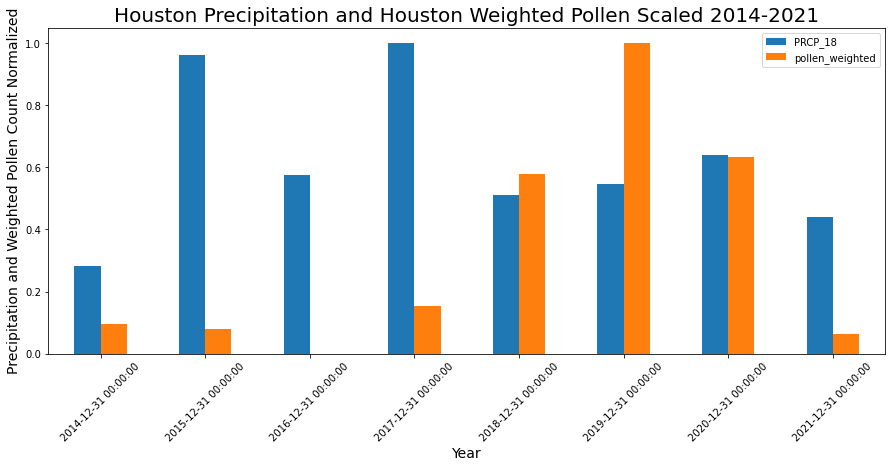

In [11]:
ax = year_groups_scaled[['PRCP_18','pollen_weighted']]['2014':'2021'].plot(kind='bar', figsize=(15,6))
ax.set_title('Houston Precipitation and Houston Weighted Pollen Scaled 2014-2021', size=20)
ax.set_xlabel('Year', size=14)
ax.set_ylabel('Precipitation and Weighted Pollen Count Normalized', size=14)
plt.xticks(rotation=45);


We expected to see higher precipitation at least affect pollen counts in the following year due to increased or decreased plant growth, but if there is such a relationship it is not clear from these data. Below looks at precipitation from shreveport, and still nothing clear. 

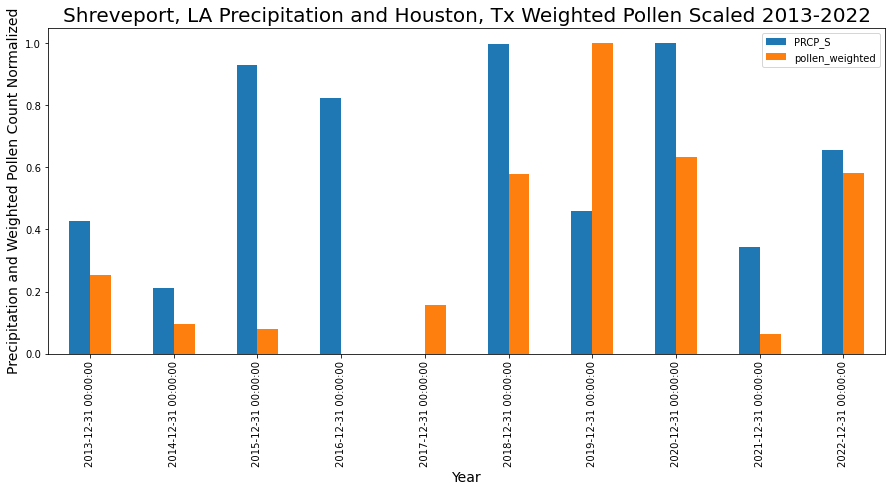

In [12]:
ax = year_groups_scaled[['PRCP_S','pollen_weighted']].plot(kind='bar', figsize=(15,6))
ax.set_title('Shreveport, LA Precipitation and Houston, Tx Weighted Pollen Scaled 2013-2022', size=20)
ax.set_xlabel('Year', size=14)
ax.set_ylabel('Precipitation and Weighted Pollen Count Normalized', size=14);

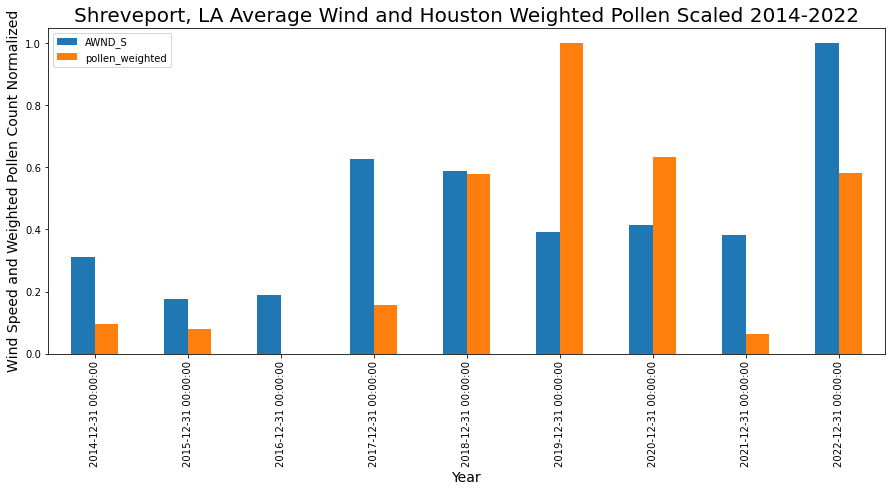

In [13]:
ax = year_groups_scaled[['AWND_S','pollen_weighted']]['2014':'2022'].plot(kind='bar', figsize =(15,6))
ax.set_title('Shreveport, LA Average Wind and Houston Weighted Pollen Scaled 2014-2022', size=20)
ax.set_xlabel('Year', size=14)
ax.set_ylabel('Wind Speed and Weighted Pollen Count Normalized', size=14);

From the above three plots it's not easy to recognize any discerinible pattern that our variables measured in either houston or shreveport affect their year's or the following year's pollen counts in Houston

Now before modeling the dataframe needs to be further cleaned.  the first 3 months of 2013 are missing for the weather data from Houston, then completing the datetime index, lastly imputing any missing values that arise from the previous step.

In [14]:
#first dropping the first 3 months of 2013, then ensuring a full datetime index, then imputing missing values
main_df = main_df.dropna(subset=['PRCP_18']).asfreq('D').interpolate()

In [15]:
# correcting the targets after the interpolation
for lvl in ['high', 'very_high', 'super_high']:
    main_df[lvl] = round(main_df[lvl])

There were a number of different techs as well as off days that were imputed. Below checks that there is no technician bias shown in the distribution

<ipython-input-16-1c6e0b7249b7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist', alpha=0.5, figsize=(15,8), fontsize=12)
<ipython-input-16-1c6e0b7249b7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist', alpha=0.5, figsize=(15,8), fontsize=12)
<ipython-input-16-1c6e0b7249b7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist', alpha=0.5, figsize=(15,8), fontsize=12)
<ipython-input-16-1c6e0b7249b7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist', alpha=0.5, figsize=(15,8), fontsize=12)
<ipython-input-16-1c6e0b7249b7>:3: UserWarning: Boolean Series key will be reindexed

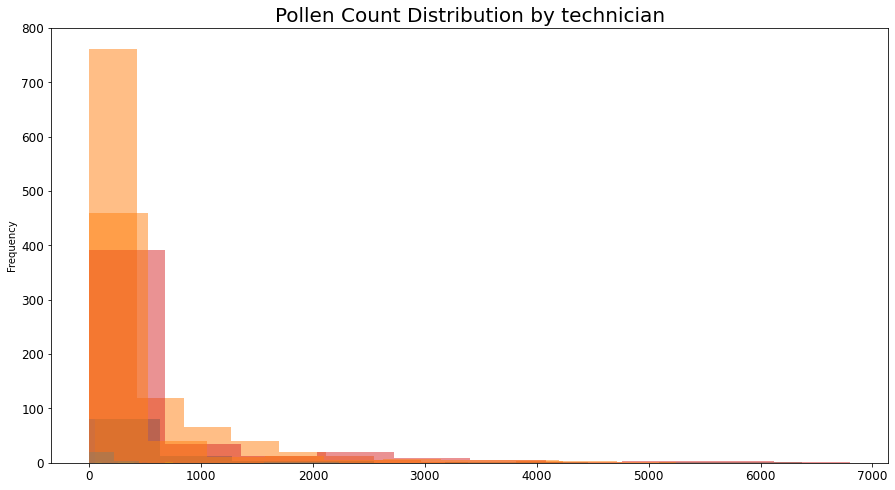

In [16]:
for tech in set(master_df['Tech.'].values):
    if tech != 'off':
        ax = main_df[master_df['Tech.']==tech]['pollen_weighted'].plot(kind='hist', alpha=0.5, figsize=(15,8), fontsize=12)
    ax.set_title('Pollen Count Distribution by technician', size=20)

<ipython-input-17-bfab7859c7a1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = np.log(main_df[master_df['Tech.']==tech]['pollen_weighted']+0.1).plot(kind='hist', alpha=0.5, figsize=(15,8))
<ipython-input-17-bfab7859c7a1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = np.log(main_df[master_df['Tech.']==tech]['pollen_weighted']+0.1).plot(kind='hist', alpha=0.5, figsize=(15,8))
<ipython-input-17-bfab7859c7a1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = np.log(main_df[master_df['Tech.']==tech]['pollen_weighted']+0.1).plot(kind='hist', alpha=0.5, figsize=(15,8))
<ipython-input-17-bfab7859c7a1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = np.log(main_df[master_df['Tech.']==tech]['pollen_weighted']+0.1).plot(kind='hist', alpha=0.5, figsize=(15,8))
<ipython-input-17-bfab7859c7a1>:3: UserWarning: Boolean Series key will be reindexed to 

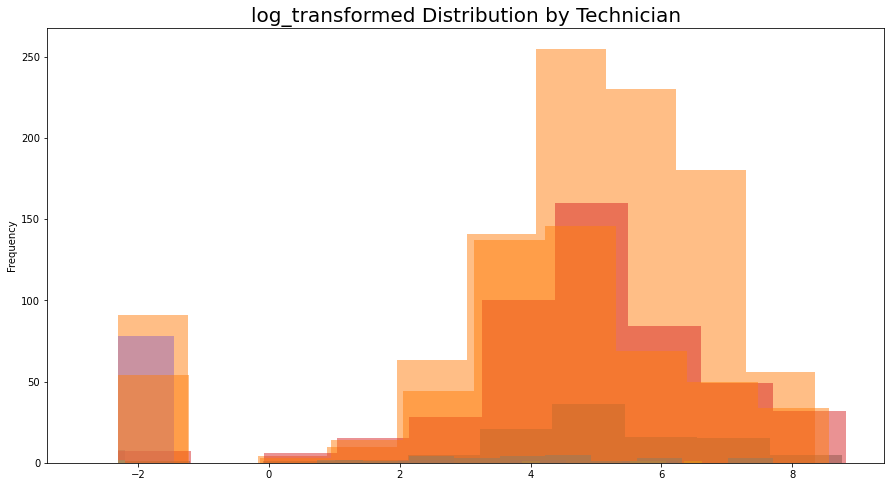

In [17]:
for tech in set(master_df['Tech.'].values):
    if tech != 'off':
        ax = np.log(main_df[master_df['Tech.']==tech]['pollen_weighted']+0.1).plot(kind='hist', alpha=0.5, figsize=(15,8))
    ax.set_title('log_transformed Distribution by Technician', size = 20)

No Apparent major differences in distribution among the various technicians. We verify equal variance with ANOVA below

In [18]:
main_df['Tech'] = main_df['Tech.'] #copying the column without the period to avoid error in formula
formula = 'pollen_weighted ~ Tech'
lm = ols(formula, main_df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
Tech,11.0,2.731948e+07,2.483589e+06,4.805172,2.206985e-07
Residual,3270.0,1.690124e+09,5.168575e+05,NaN,NaN


With an F score below 5, it shows there is little variance between Technicians' pollen count readings. having shown that technician is irrelevant, it is dropped from the data before correlations are explored in heatmaps

In [19]:
##dropping tech from the dataframe now that 
main_df.drop(['Tech.', 'Tech'], axis=1, inplace=True)

In [20]:
#saving this down for the modeling with seasonality notebook
main_df.to_csv('data/main_df.csv')

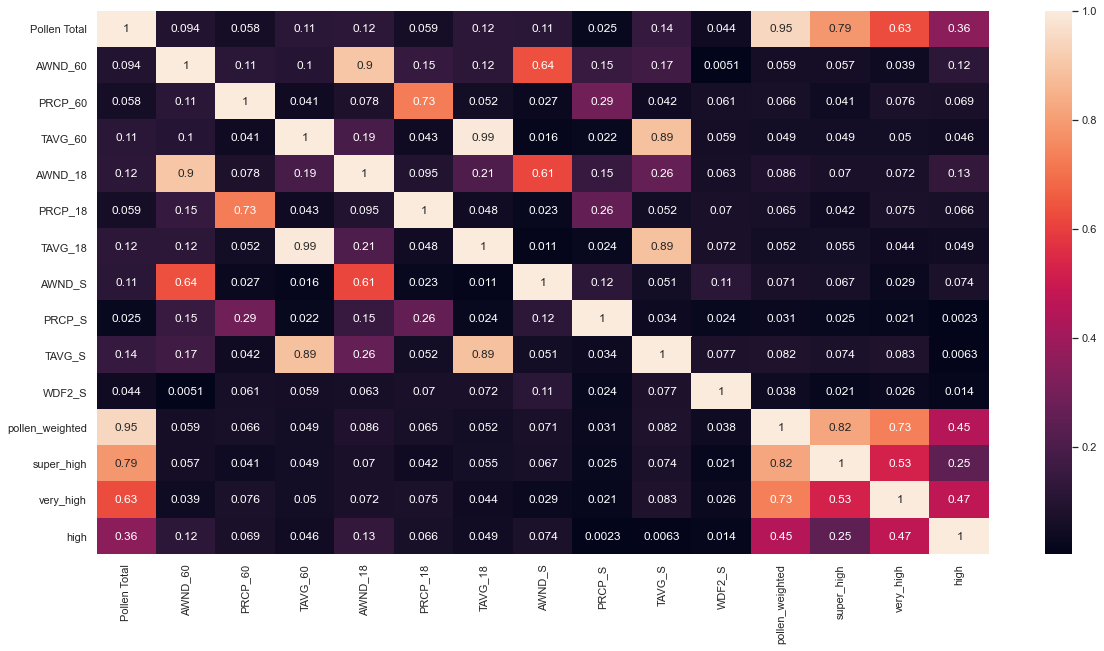

In [21]:
sns.set(rc = {'figure.figsize': (20,10)}, style='white')
sns.heatmap(main_df.corr().abs(), annot=True);

No strong correlations of pollen count. We see that a "high" pollen data appears correlated to average wind speed `AWND_18` from one of the 

<AxesSubplot:>

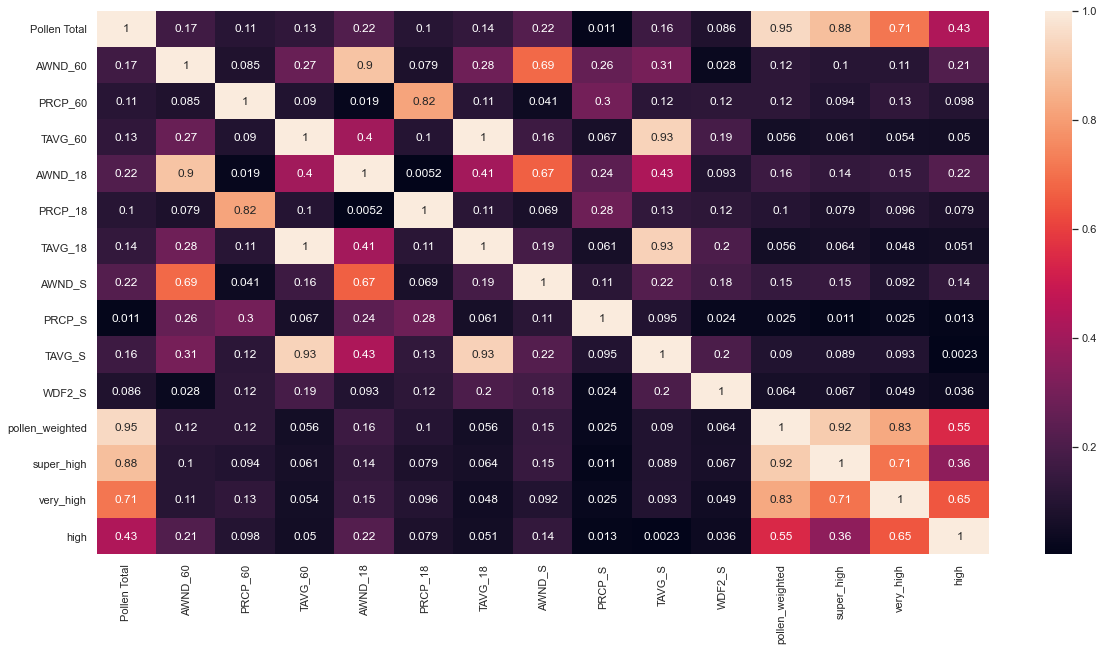

In [22]:
sns.heatmap(main_df.resample('W').mean().corr().abs(), annot=True)

Upsampling to weekly shows stronger corrrelations, however the downside is the number of data points for modeling would be divided by 7.

# 5) Modeling With Differenced and Decomposed Data
The modeling portion of this report consists of two parts: Pollen Level Classification and Time Series Forecasting. Given that all of the variables appear to have seasonality. The correlations shown so far are likely merely a consequence of that. Modeling seasonal pollen levels from seasonal variables should be straightforward to address

The next question this report first hopes to address is if, with all trends removed, can a classification model such as logistic regression with these variables outperform a dummy classifier. 

The next question, much simpler, relies on this seasonality to forecast pollen levels reliably for Houston. While this is not a classifiction model, the predicted pollen counts are the basis for the classification targets and thus can be applied directly. 

The forecasting could then be applied to the further considerations, where, as proof of concept, artificial customers and medication purchases are generated to show how species data can be used as a diagnostic tool for allergen identification.

## 5a) Modeling with Differenced Data
Differencing is the most popular technique for removing trends, seasonality, etc. and making a time-series stationary so the modeling starts there

In [23]:
# preparing the train/test split for logistic regression
X = main_df.drop(columns=['Pollen Total', 'pollen_weighted', 'super_high', 'very_high', 'high']).diff().interpolate().bfill()
y= main_df['high']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

In [24]:
ss_s = StandardScaler()

X_train_scaled = ss_s.fit_transform(X_train)
X_test_scaled = ss_s.transform(X_test)

### Dummy Classifier
A dummy classifier that always returns the majority class was chosen as a baseline model

In [25]:
#showing the class breakdown of our data in percentage a 1.0 indicates a 'high' pollen data
y_test.value_counts(normalize=True)

1.0    0.512158
0.0    0.487842
Name: high, dtype: float64

In [26]:
baseline_model_s = DummyClassifier(strategy='most_frequent')
baseline_model_s.fit(X_train_scaled, y_train)
print('Accuracy:', baseline_model_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, baseline_model_s.predict(X_test_scaled)))

Accuracy: 0.5121580547112462 Precision: 0.5121580547112462


51% of the days in our test data are `high` pollen days so that is the best the dummy model can do. We next try logistic regression:

## First Logistic Regression for data with differenced data

In [27]:
lr1_s = LogisticRegression(random_state=85)
lr1_s.fit(X_train_scaled, y_train)
print('Accuracy:', lr1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, lr1_s.predict(X_test_scaled)))

Accuracy: 0.5379939209726444 Precision: 0.5294117647058824


This outperforms the baseline, barely. There is high multicolinearity in this data so it makes more sense to use a decision tree or random forest classifier

## First Decision Tree Classifier with differenced data

In [28]:
dt1_s = DecisionTreeClassifier(random_state=85)
dt1_s.fit(X_train_scaled, y_train)
print('Accuracy:', dt1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, dt1_s.predict(X_test_scaled)))

Accuracy: 0.4939209726443769 Precision: 0.5056497175141242


This decision tree does even worse than the baseline model so hyperparameters must be adjusted
## Second Desicion Tree with Differenced data
To start we'll tweak one parameter `max_depth` to see if that improves it at all

In [29]:
dt2_s = DecisionTreeClassifier(random_state=85, max_depth=6)
dt2_s.fit(X_train_scaled, y_train)
print('Accuracy:', dt2_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, dt2_s.predict(X_test_scaled)))

Accuracy: 0.5623100303951368 Precision: 0.5531453362255966


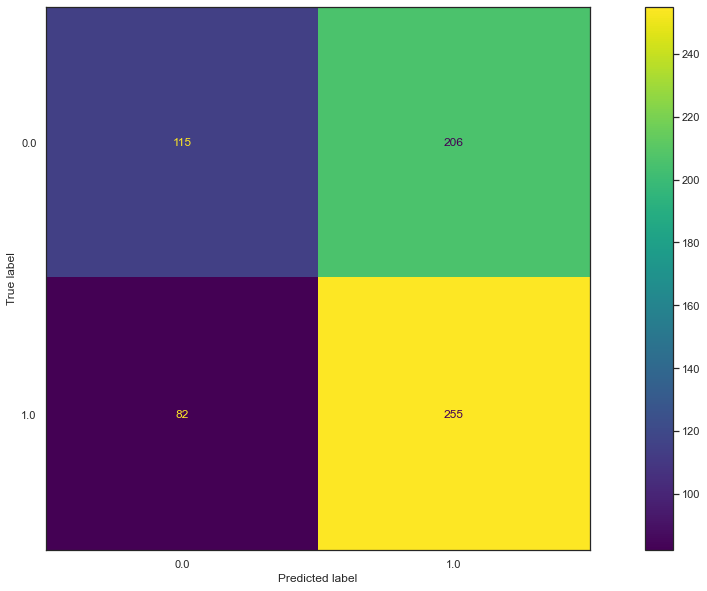

In [30]:
plot_confusion_matrix(dt2_s, X_test_scaled, y_test)

Modest improvement in both metrics here so it's followed up with a grid search of paramaters to see if it can produce even more accurate results
### Grid Search for decision tree parameters

In [31]:
#The parameters to be iterated over in decision tree models
param_grid_dt_s = {
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 10, 20, None],
      'min_samples_leaf':[1,  3, 4, 5, 6, 10]
 }
    
gridsearch_dt_s= GridSearchCV(estimator=DecisionTreeClassifier(random_state=85),
                  param_grid=param_grid_dt_s,
                  cv=10,
                  )

grid_results_dt_s = gridsearch_dt_s.fit(X_train_scaled, y_train)

In [32]:
#shows the parameters discovered by the grid search to optimize the model
grid_results_dt_s.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10}

These parameters are applied to a new model
## Grid Search Decision Tree with Differenced Data

In [33]:
grid_dt_s = DecisionTreeClassifier(random_state=85, criterion='entropy', max_depth=4, min_samples_leaf=1)

grid_dt_s.fit(X_train_scaled, y_train)
print('Accuracy:', grid_dt_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, grid_dt_s.predict(X_test_scaled)))

Accuracy: 0.5683890577507599 Precision: 0.5555555555555556


model performance:
grid search does not always produce the best results, but can offer a hint at where to make changes which will happen for the final Decision Tree model
## Final Decision Tree Model with Differenced Data


In [34]:
final_dt_s = DecisionTreeClassifier(random_state=85, max_depth=4, min_samples_leaf=6 )

final_dt_s.fit(X_train_scaled, y_train)
print('Accuracy:', final_dt_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, final_dt_s.predict(X_test_scaled)))

Accuracy: 0.5699088145896657 Precision: 0.5567226890756303


 This has the best performace so far on both precision and accuracy, 57% and 56% respectively. Given the success of a single decision tree, the next models will be random forest classifiers
## First Random Forest Classifer with Differenced Data

In [35]:
rfc1_s = RandomForestClassifier(random_state=85)

rfc1_s.fit(X_train_scaled, y_train)
print('Accuracy:', rfc1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, rfc1_s.predict(X_test_scaled)))

Accuracy: 0.5911854103343465 Precision: 0.5862944162436549


Again improvement is seen, so it makes sense to proceed as before with a grid search
### Grid Search for Random Forest Classifier with Differenced Data


In [36]:
#The parameters to be iterated over in decision tree models
param_grid_rfc_s = {
      'n_estimators':[50, 100, 500],
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 10, 20, None],
      'min_samples_leaf':[1, 3, 4, 5, 6, 10]
 }
    
gridsearch_rfc_s= GridSearchCV(estimator=RandomForestClassifier(random_state=85),
                  param_grid=param_grid_rfc_s,
                  cv=10,
                  )

grid_results_rfc_s = gridsearch_rfc_s.fit(X_train_scaled, y_train)

In [37]:
#returns best parameters for the Random Forest
grid_results_rfc_s.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 10,
 'n_estimators': 50}

Taking these parameters identified by the grid search to use on our next Random Forest
## Grid Search Random Forest Classifier with Differenced Data

In [134]:
grid_rfc_s = RandomForestClassifier(random_state=85, max_depth=None, 
                                    criterion='entropy', min_samples_leaf=10, n_estimators=50)

grid_rfc_s.fit(X_train_scaled, y_train)
print('Accuracy:', grid_rfc_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, grid_rfc_s.predict(X_test_scaled)))

Accuracy: 0.547112462006079 Precision: 0.5469879518072289


This is less successful than the prior model. Again we see if tweaking these parameters manually can improve the model further
## Final Random Forest Classifier with Differenced Data

In [137]:
final_rfc_s = RandomForestClassifier(random_state=85, max_depth=43, criterion='gini', n_estimators=95)

final_rfc_s.fit(X_train_scaled, y_train)
print('Accuracy:', final_rfc_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, final_rfc_s.predict(X_test_scaled)))

Accuracy: 0.5987841945288754 Precision: 0.5905707196029777


With an accuracy of 60% and precision score of 59%, this is the best model for differenced data

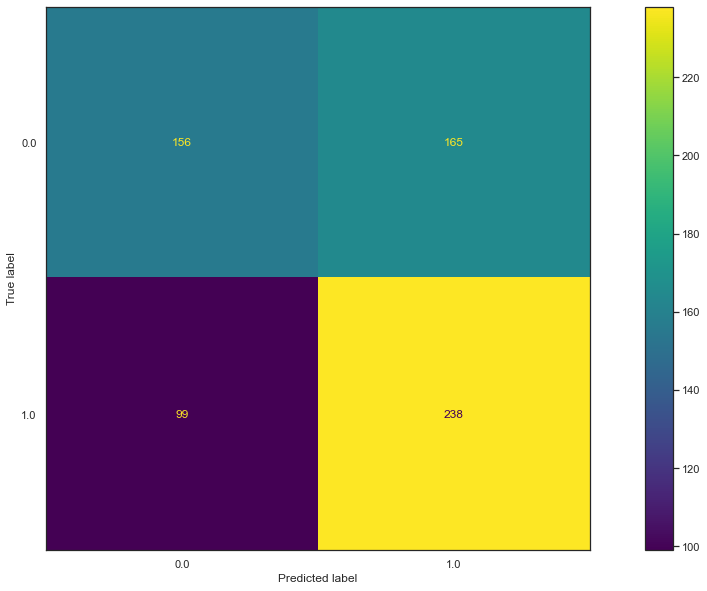

In [40]:
#confusion matrix for final RFC 
plot_confusion_matrix(final_rfc_s, X_test_scaled, y_test);

The best classification model for seasonal pollen is the Random Forest Classifier above with 60% accuracy and 59%% precision. Again all these data fluctuate seasonally, so we next try to tackle the question of, do these climate variables still have any predictive power when seasonality is taken out. Given the high seasonal regularity of pollen counts and the climate variables,  a K nearest neighbors model should be considered 

## K-Nearest Neighbors Model for differenced data

In [41]:
knn_scores =[]
num_neighbors = []
best_nn = []
for num in range(1,100):
    knn_scores.append(KNeighborsClassifier(n_neighbors=num).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))
    num_neighbors.append(num)
knn_dict = dict(zip(num_neighbors, knn_scores))
for x in knn_dict:
    if knn_dict[x] == max(knn_scores):
        best_nn = [x]
best_nn

[97]

In [42]:
knn = KNeighborsClassifier(n_neighbors=97)

knn.fit(X_train_scaled, y_train)
print('Accuracy:', knn.score(X_test_scaled, y_test), ', Precision:', precision_score(y_test, knn.predict(X_test_scaled)))

Accuracy: 0.5759878419452887 , Precision: 0.5687203791469194


Having iterated over number of neighborss, it was discovered that 97 nearest neighbors provides the best scores for this model. This is worse-fitting than the Random Forest with an accuracy here at 58%% and a precision score 57%. 

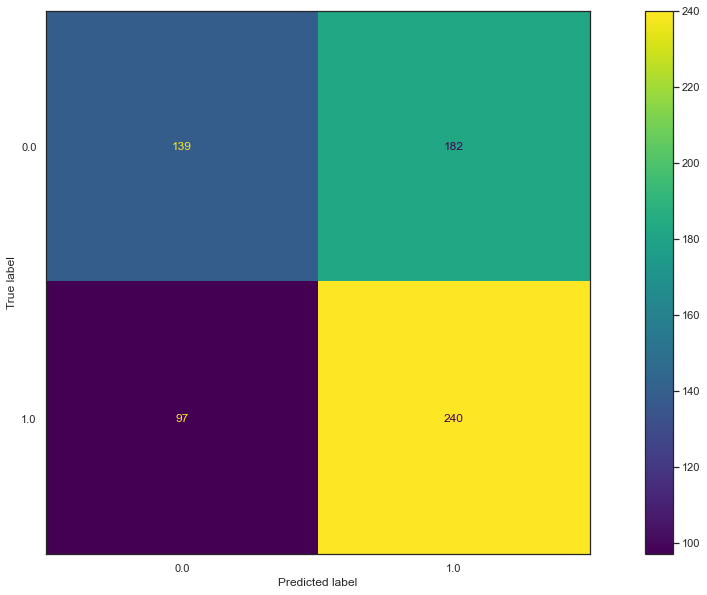

In [43]:
plot_confusion_matrix(knn, X_test_scaled, y_test);


# 5b) Modeling The Residuals of Seasonal Decomposition
in order to separate the seasonal component from the data, we try seasonal decomposition and isolate the residuals

### Seasonal Decomposition
given the high seasonlity of both target and variables, the first step is to remove that dependence from the data.

In [44]:
#uses stats models' seasonal_decompose to break the data into its trend and seasonal components
decomp_pollen = seasonal_decompose(main_df['pollen_weighted'].resample('D').mean(), extrapolate_trend='freq', period=365)

''

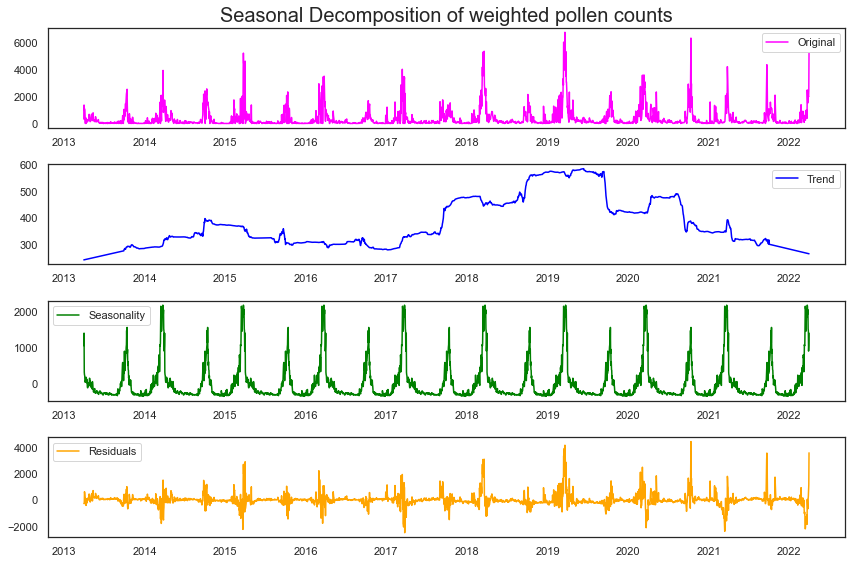

In [45]:
#isolating the decomposed elements
trend = decomp_pollen.trend
seasonal = decomp_pollen.seasonal
residual = decomp_pollen.resid

# plotting the decomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(main_df['pollen_weighted'], label='Original', color='magenta')
plt.title('Seasonal Decomposition of weighted pollen counts', size=20)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='orange')
plt.legend(loc='best')
plt.tight_layout()
;

The above shows the break down of our decomposed `pollen_weighted` data. To the eye it still looks as if there are seasonal fluctuations in the residuals, but this worked better than differencing (Appendix)

The point in this section is to remove the seasonal component from all elements in the dataframe. This is performed below where a dataframe of only the decomposed residuals of all columns into a new dataframe

In [46]:
# applying the seasonal_decompose function to all columns and reforming it into a new dataframe
df_resid = main_df.resample('D').mean().apply(lambda x: seasonal_decompose(x, extrapolate_trend='freq').resid)
df_trend = main_df.resample('D').mean().apply(lambda x: seasonal_decompose(x, extrapolate_trend='freq').trend)
df_resid_trend = df_resid+df_trend
df_resid_trend.head()

,Pollen Total,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high
DATE,,,,,,,,,,,,,,,
2013-04-01,1048.514526,5.914885,-0.008414,66.933203,5.667954,-0.032124,66.984706,2.386748,0.007795,62.922404,166.624599,1048.726374,0.002916,1.017801,1.049086
2013-04-02,1338.693762,9.761012,1.477976,66.697510,9.833483,1.541333,67.726076,6.978422,0.146503,60.199168,31.521255,1376.210161,-0.000329,1.000715,0.970265
2013-04-03,262.162264,10.361799,0.186130,62.853329,12.158925,0.130491,63.810673,8.355177,0.151698,44.858693,44.367760,274.709630,-0.012520,-0.001565,0.997827
2013-04-04,1052.126115,10.916316,0.011303,53.084017,12.678216,0.033528,54.034240,6.287265,-0.019696,44.146226,313.112875,1068.899805,-0.016200,0.987970,0.972295
2013-04-05,898.697720,4.486033,0.013859,56.236680,5.552705,0.034395,57.214809,1.231493,0.010017,53.150191,40.088155,947.287547,0.002010,0.996126,1.014880


In [47]:
#resetting the target columns back to original values which were also decomposed above
df_resid = df_resid.drop(columns=['super_high', 'very_high', 'high'])
df_resid_trend = df_resid_trend.drop(columns=['super_high', 'very_high', 'high'])
target_df=main_df[['super_high','very_high','high']]

In [48]:
#checking that our target has been restored
target_df['high'].value_counts(normalize=True)

1.0    0.522969
0.0    0.477031
Name: high, dtype: float64

In [49]:
#reforming the data frame with residual variables and original targets
model_resid = pd.concat([df_resid,target_df], axis=1)
model_wtrend = pd.concat([df_resid_trend,target_df], axis=1)

First it makes sense to see if there are any correlations in the data with seasonality purportedly removed

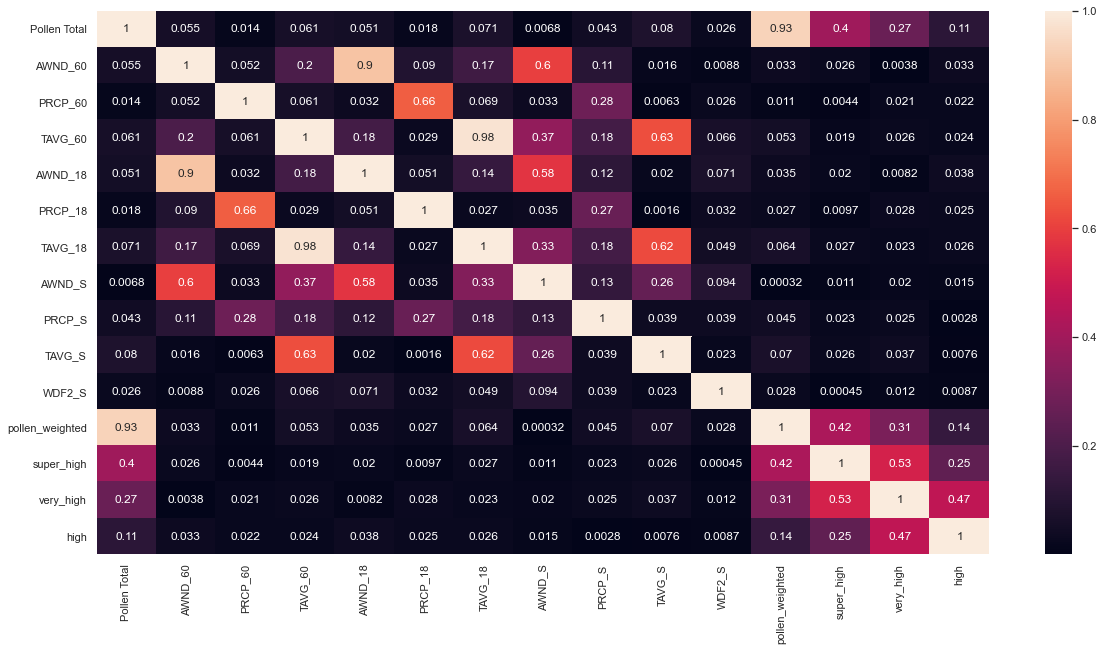

In [50]:
#correlation heatmap
sns.heatmap(model_resid.corr().abs(), annot=True);

having removed seasonality, it is evident that there are now no exceptionally strong correlations between pollen levels and the weather realted variables. Nonetheless, the point of this report is to provide a classification model

In [51]:
# preparing the train/test split for logistic regression
X_r = model_resid.drop(columns=['Pollen Total', 'pollen_weighted', 'super_high', 'very_high', 'high'])
y_r= model_resid['high']

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=0.2, random_state=85)

## Baseline Dummy Classifier
A dummy classifier that chooses the majority class is used as the baseline model

In [52]:
baseline_model = DummyClassifier(random_state=85, strategy='most_frequent')

baseline_model.fit(X_r_train,y_r_train)

DummyClassifier(random_state=85, strategy='most_frequent')

In [53]:
print('Accuracy:', baseline_model.score(X_r_test, y_r_test), 
      ', Precision:', precision_score(y_test, baseline_model.predict(X_r_test)))

Accuracy: 0.5121580547112462 , Precision: 0.5121580547112462


51% accurate, just as expected

## First Logistic Regression for Seasonally Decomposed Residuals
first employed will be a standard logistic regression model without the bells and whistles. Data will be scaled.

In [54]:
ss = StandardScaler()

X_r_train_sc = ss.fit_transform(X_r_train)
X_r_test_sc = ss.transform(X_r_test)

In [55]:
lr1 = LogisticRegression(random_state=85)

lr1.fit(X_r_train_sc, y_r_train)
print('Accuracy:', lr1.score(X_r_test_sc, y_r_test), ', Precision:', precision_score(y_r_test, lr1.predict(X_r_test_sc)))

Accuracy: 0.5106382978723404 , Precision: 0.5136116152450091


The logisitic regression perform even worse than  dummy classifier! Yet again, due to the high multiconlinearity that violate assumptions for this type of model, it makes sense to switch gears and move on to another machine learning model that be more appropriate and accurate

## First Decision Tree for Seasonally Decomposed Residuals
The next model tried is decision tree model with a max depth of 4. This depth was chosen after a few attempts of minor manipulation. 

In [56]:
dt1 = DecisionTreeClassifier()
dt1.fit(X_r_train_sc, y_r_train)
print('Accuracy:', dt1.score(X_r_test_sc, y_r_test), ', Precision:', precision_score(y_test, dt1.predict(X_r_test_sc)))

Accuracy: 0.5030395136778115 , Precision: 0.5142045454545454


This only performs only *slightly* better on accuracy and precision than the baseline model. The next model attempts to adjust hyperparameters of the decision tree.

## Second Decision Tree for Seasonally Decomposed Residuals
first we try tweaking one hyperparameter of the decision tree, `max_depth`, 

In [57]:
dt2 = DecisionTreeClassifier(max_depth=4)
dt2.fit(X_r_train_sc, y_r_train)
print('Accuracy:', dt2.score(X_r_test_sc, y_r_test), ', Precision:', precision_score(y_test, dt2.predict(X_r_test_sc)))

Accuracy: 0.5547112462006079 , Precision: 0.5654761904761905


With 55% accuracy, the decision tree has successfully outperformed the dummy, but only just. It hints that there may be a slightly more than random relationship between the chosen variables and airborne pollen levels. The confusion matrix shows the breakdown of false/true positives and negatives:

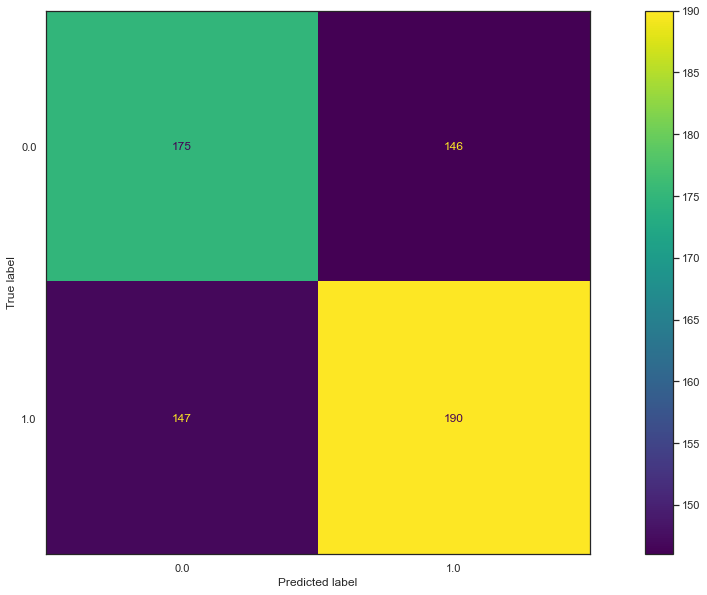

In [58]:
plot_confusion_matrix(dt2, X_r_test_sc, y_r_test)

To see which features were identified as important by this decision tree its dendrogram is visualized below

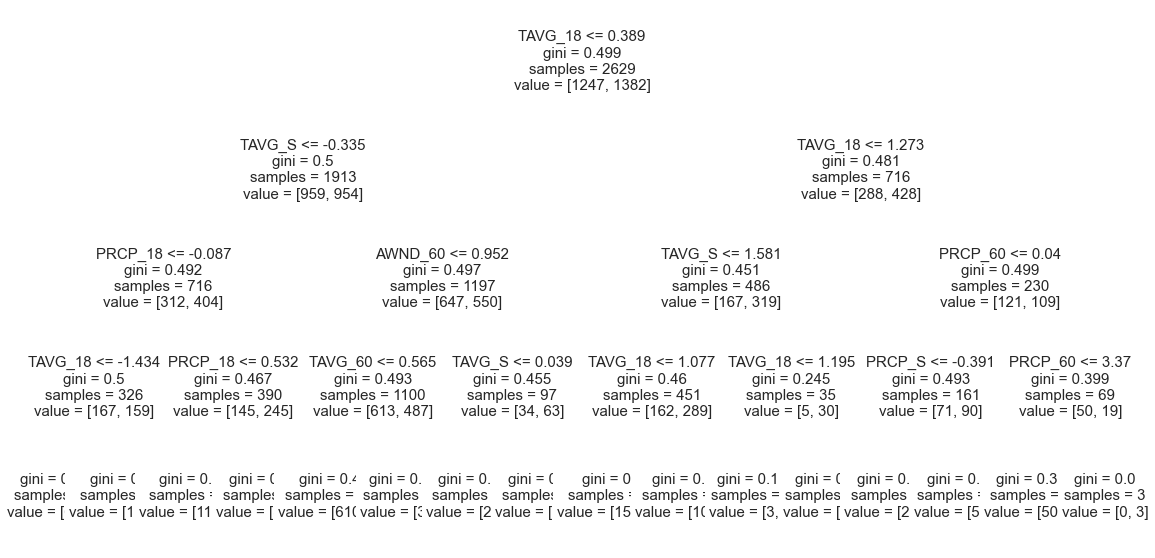

In [59]:
plot_tree(dt2, fontsize=15, feature_names=X.columns);

Somewhat surprisingly, this decision tree has decided that the average temperature in Houston `TAVG_18` is the most important factor followed by average temperature in Shreveport, LA `TAVG_S` in making splits. . 

This relationship with temperature may only be a relic of seasonality. However it also may point to other phenomena such as the effect of temperature on air pressure and air currents and convection effects that lift pollen towards the upper atmosphere. Houston wind speed and precipitation were the next most important features according to this particular model. It is prudent to explore the parameters a decision tree model in order to maximize accuracy, yet given the relative success of the single decision tree, it bears to reason that multiple decision trees might perform even better, as it did in section 5a.

With 55% Accuracy and 57% precision, this modified decision tree has outperformed

## Grid Search Decision Tree Classifier for Seasonally Decomposed Residuals
Seeing the improvement in the model from one parameter adjustment from the first decision tree it makes sense to try a grid search to determine the ideal parameters.

In [60]:
#The parameters to be iterated over in decision tree models
param_grid_dt = {
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 10, 20, None],
      'min_samples_leaf':[1,  3, 4, 5, 6, 10]
 }
    
gridsearch_dt= GridSearchCV(estimator=DecisionTreeClassifier(random_state=85),
                  param_grid=param_grid_dt_s,
                  cv=10,
                  )

grid_results_dt = gridsearch_dt.fit(X_train_scaled, y_train)

In [61]:
#extracting the optimized parameters
grid_results_dt.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10}

In [62]:
gs_dt = DecisionTreeClassifier(random_state=85, criterion='entropy', max_depth=10, min_samples_leaf=10 )
gs_dt.fit(X_r_train_sc, y_train)

print('Accuracy:', gs_dt.score(X_r_test_sc, y_r_test), ', Precision:', precision_score(y_test, gs_dt.predict(X_r_test_sc)))

Accuracy: 0.5075987841945289 , Precision: 0.5186246418338109


This Actually performs worse than both the dummy baseline AND the manually tweaked Decision Tree. One last attempt is performed to optimize accuracy and precision
## Final Decision Tree Classifier

In [63]:
final_dt = DecisionTreeClassifier(random_state=85, criterion='gini', max_depth=4, min_samples_leaf=20)
final_dt.fit(X_r_train_sc, y_r_train)

print('Accuracy:', final_dt.score(X_r_test_sc, y_r_test), ', Precision:', precision_score(y_r_test, 
                                                                                      final_dt.predict(X_r_test_sc)))

Accuracy: 0.5577507598784195 , Precision: 0.5701219512195121


By a very small margin, this final Decision Tree is the best of this type of models. Given the success of a single decision tree, a random forest model with multiple trees makes for the next step.
## First Random Forest Classifier for Seasonally Decomposed Residuals

In [64]:
rfc1 = RandomForestClassifier(random_state=85)
rfc1.fit(X_r_train_sc, y_r_train)
print('Accuracy:', rfc1.score(X_r_test_sc, y_test), ', Precision:', precision_score(y_r_test, rfc1.predict(X_r_test_sc)))

Accuracy: 0.5851063829787234 , Precision: 0.5820512820512821


Assumptions were correct and the Random Forest is the best classifier so far in terms of accuracy, *59%* and precision, *58%* for decomposed residuals. The second attempt, keeping in fashion with the rest of the models, will make a tweak to the `max_depth` parameter.

## Second Random Forest Classifier for Seasonally Decomposed Residuals

In [65]:
rfc2 = RandomForestClassifier(random_state=85, max_depth=5)
rfc2.fit(X_r_train_sc, y_r_train)
print('Accuracy:', rfc2.score(X_r_test_sc, y_test), ', Precision:', precision_score(y_r_test, rfc2.predict(X_r_test_sc)))

Accuracy: 0.5653495440729484 , Precision: 0.5645569620253165


This performs worse than the first Random Forst which had default hyperparameters in place. The next logical step is to do a grid search to find parameters that yield the best RFC for this decomposed data.

In [66]:
#setting up the paramaters to iterate over
param_grid_rfc = {
      'n_estimators':[50, 100, 500],
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 5, 6, 10, None],
      'min_samples_leaf':[1, 3, 5, 10, 20]
 }
    
gridsearch= GridSearchCV(estimator=RandomForestClassifier(random_state=85),
                  param_grid=param_grid_rfc,
                  cv=10,
                  )

grid_results = gridsearch.fit(X_r_train_sc, y_r_train)

In [67]:
#outputs best parameters acc to grid search above
grid_results.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'n_estimators': 100}

the grid search has provided the best paramaters (shown above) for the random forest classifier and will be implemented in the final model below
## Grid Search Random Forest Classifier for Seasonally Decomposed Residuals

In [68]:
grid_rfc = RandomForestClassifier(random_state=85, criterion = 'gini', max_depth=6, min_samples_leaf=1, n_estimators=100)

grid_rfc.fit(X_r_train_sc, y_r_train)
print('Accuracy:', grid_rfc.score(X_r_test_sc, y_test), 
      ', Precision:', precision_score(y_r_test, grid_rfc.predict(X_r_test_sc)))

Accuracy: 0.5638297872340425 , Precision: 0.5631313131313131


This actually does worse in terms of accuracy. The first model with default parameters did best. Tweaking the default parameters slightly by hand results in the best model for this data.

## Final Random Forest Classifer for Seasonally Decomposed Residuals

In [69]:
rfc_final = RandomForestClassifier(random_state=85, criterion='gini', max_depth=100, min_samples_leaf=1, n_estimators=200)

rfc_final.fit(X_r_train_sc, y_r_train)
print('Accuracy:', rfc_final.score(X_r_test_sc, y_test), 
      ', Precision:', precision_score(y_r_test, rfc_final.predict(X_r_test_sc)))

Accuracy: 0.5987841945288754 , Precision: 0.5910224438902744


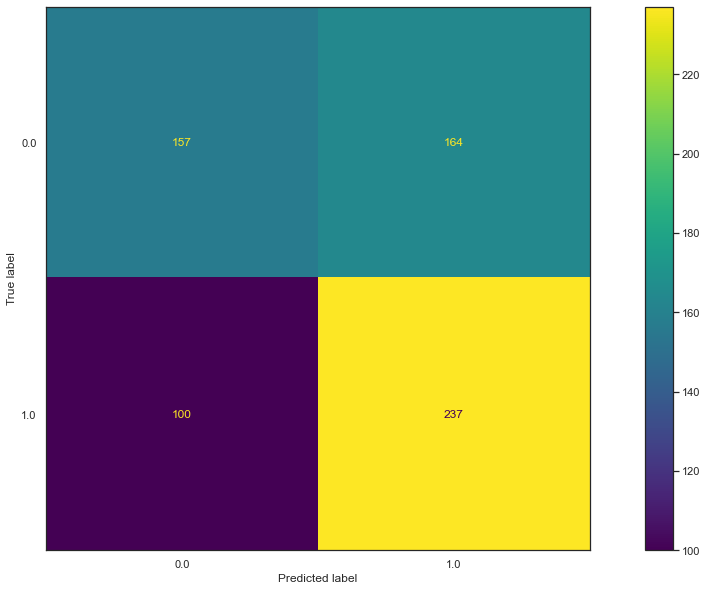

In [70]:
plot_confusion_matrix(rfc_final, X_r_test_sc, y_r_test);

with 60% accuracy and 59%% precision this is the best classification model for the decomposed residuals. Is it possible to conclude that daily climate conditions have *some* influence over pollen levels regardless of seasonality? Probably not for sure. If one takes a closer look at the original residuals, and the climate data in the residuals dataframe, it's hard not see that some seasonality remains despite what the `seasonal_decompose` function accomplished.

## K Nearest Neighbors for Decomposed Residual
Again it's prudent to try 1 alternative machine learning model for the data

In [131]:
knn_scores_2 =[]
num_neighbors_2 = []
best_nn_2 = []
for num in range(1,100):
    knn_scores_2.append(KNeighborsClassifier(n_neighbors=num).fit(X_r_train_sc, 
                                                                  y_r_train).score(X_r_test_sc, y_r_test))
    num_neighbors_2.append(num)
knn_dict_2 = dict(zip(num_neighbors_2, knn_scores_2))
for x in knn_dict_2:
    if knn_dict_2[x] == max(knn_scores_2):
        best_nn_2 = [x]
best_nn_2

[40]

In [132]:
knn_2 = KNeighborsClassifier(n_neighbors = 40)
knn_2.fit(X_r_train_sc, y_r_train)

print('Accuracy:', knn_2.score(X_r_test_sc, y_r_test), ', Precision:', 
      precision_score(y_r_test, knn_2.predict(X_r_test_sc)))

Accuracy: 0.5820668693009119 , Precision: 0.5807291666666666


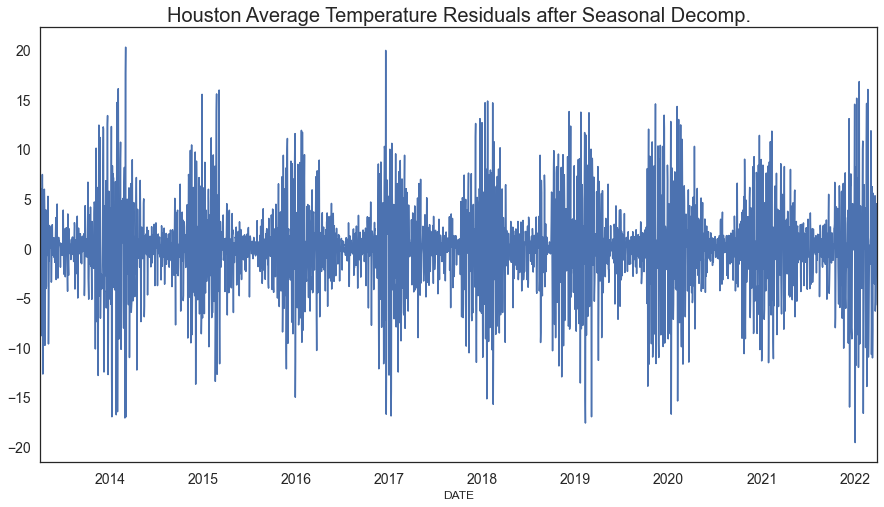

In [71]:
#visualizing the seemingly seasonal pattern that remains in one of the variables, local temp, even after seasonal decomp.
ax = model_resid['TAVG_18'].plot(fontsize=14, figsize=(15,8))
ax.set_title('Houston Average Temperature Residuals after Seasonal Decomp.', size=20);

Clearly seasonality wasn't removed from all the data so much as muffled a bit, which makes sense given that all the models with seasonality outperformed their counterparts in this section. Thus the question still remains. 

Interestingly enough, when decomposing an upsampled weekly data, the `seasonal_decompose` function appears to successfully remove all seasonality from the residuals as demonstrated in the following section

# 5c) Exploring Weekly Data

As mentioned above the upsampled weekly data appears fully decomposed yielding a much more 'white-noise'-esque picture:
### Seasonal Decomposition of Weekly Averages

In [72]:
#uses stats models' seasonal_decompose to break the data into its trend and seasonal components
decomp_pollen_weekly = seasonal_decompose(main_df['pollen_weighted'].resample('W').mean(), extrapolate_trend='freq',
                                         period=52)

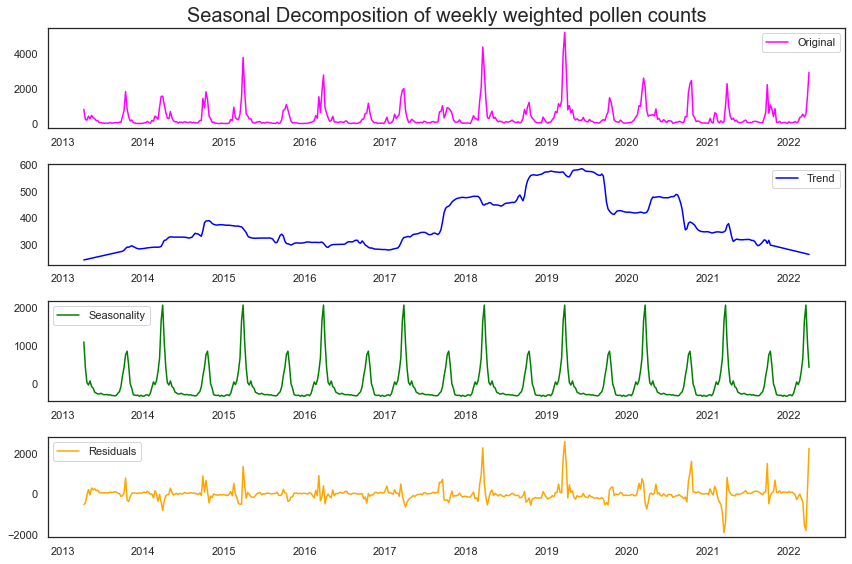

In [73]:
### isolating the decomposed elements
trend_w = decomp_pollen_weekly.trend
seasonal_w = decomp_pollen_weekly.seasonal
residual_w = decomp_pollen_weekly.resid

# plotting the decomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(main_df['pollen_weighted'].resample('W').mean(), label='Original', color='magenta')
plt.title('Seasonal Decomposition of weekly weighted pollen counts', size=20)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_w, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_w,label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_w, label='Residuals', color='orange')
plt.legend(loc='best')
plt.tight_layout()

There are many advantages of using weekly data, as it gives a better picture of the whole week. the major disadvantage in this case, however, is the limited number of observations is yields, roughly 500. This is usually not enough for modeling. This concept is further explored in the appendix

In [74]:
#creating a dataframe of weekly residuals
df_resid_w = main_df.resample('W').mean().apply(lambda x: seasonal_decompose(x, extrapolate_trend='freq').resid)

In [75]:
#resetting the target such that if the majority of days in the week were high pollen the week is classified as high pollen
df_resid_w['high'] = round(main_df.resample('W').mean()['high'])
df_resid_w

,Pollen Total,AWND_60,PRCP_60,TAVG_60,AWND_18,PRCP_18,TAVG_18,AWND_S,PRCP_S,TAVG_S,WDF2_S,pollen_weighted,super_high,very_high,high
DATE,,,,,,,,,,,,,,,
2013-04-07,-480.288831,-1.035782,0.156169,-4.208823,-0.743707,0.200080,-4.255044,-0.593279,-0.205918,-4.828148,-59.760469,-525.383735,-0.333813,-0.052040,1.0
2013-04-14,-397.017753,1.407825,0.079170,-0.822394,0.599626,0.173515,-0.916237,0.592799,0.233279,2.100171,15.700482,-435.879645,-0.077474,-0.453199,1.0
2013-04-21,-63.072042,2.149787,-0.114130,-2.661268,1.400168,-0.109178,-3.201407,2.413829,-0.017341,1.020376,3.472638,-67.717418,0.024624,-0.220131,1.0
2013-04-28,58.967490,0.714229,-0.184082,-1.864354,0.747530,0.683675,-2.273074,0.131300,-0.215959,0.391762,-2.488089,218.222845,0.039912,0.129422,1.0
2013-05-05,-4.058912,0.030198,0.013632,-3.452361,0.415319,0.051795,-3.523007,0.830230,-0.099257,-3.099414,-4.733920,-49.087960,0.023453,-0.172276,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-06,-466.828077,-1.434213,-0.152117,-1.319083,-1.689967,-0.111002,-2.341634,-2.524714,-0.312216,3.151551,25.902157,-401.322714,-0.269696,-0.154947,1.0
2022-03-13,-1569.422308,2.134378,-0.048061,-13.482118,1.038380,0.022889,-14.192856,0.418334,0.094651,-12.667801,16.964742,-1548.982480,-0.570617,-0.424338,1.0
2022-03-20,-1784.573546,0.858999,0.004566,-2.603639,1.144892,0.049495,-3.462576,-0.412828,0.161249,-4.162138,-1.940622,-1803.070359,-0.569799,-0.392143,1.0


In [76]:
#inspecting the class break down
df_resid_w['high'].value_counts(normalize=True)

1.0    0.52766
0.0    0.47234
Name: high, dtype: float64

In [77]:
#Creating a train test split from upsampled weekly data 
X_w = df_resid_w.drop(columns=['high', 'super_high', 'very_high', 'Pollen Total', 'pollen_weighted'])
y_w = df_resid_w['high']
            
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.2, random_state=85)

In [78]:
#setting up a random forest classifier for the weekly data
rfc_weekly = RandomForestClassifier(random_state=85, max_depth=5)
rfc_weekly.fit(X_train_w, y_train_w)

RandomForestClassifier(max_depth=5, random_state=85)

In [79]:
print('Accuracy:', rfc_weekly.score(X_test_w, y_test_w), 
                                    ', Precision:', precision_score(y_test_w, rfc_weekly.predict(X_test_w)))

Accuracy: 0.4787234042553192 , Precision: 0.47761194029850745


From above it's evident that modeling based off of weekly data is even less successful than modeling from daily data.
Perhaps what's even more important for consumers than classification is forecasting with time series models. 
# 6) Time Series Modeling


There is an obvious seasonal component to the data, this is explored below with a variety of time series predicted models. The growth of pollen counts is exponential and the distribution of the data is more normal after weighted pollen counts are log-transformed. 

In [80]:
#creating a new dataframe with log_transformed values
log_df = main_df.copy()
log_df['log_pollen'] = np.log(log_df['pollen_weighted'])
log_df[log_df['log_pollen'] == log_df['log_pollen'].min()] = np.nan
log_df['log_pollen'].interpolate(method='time', inplace=True)

C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Visually inspecting the distributions of pre and post log-transformed pollen counts shown below:

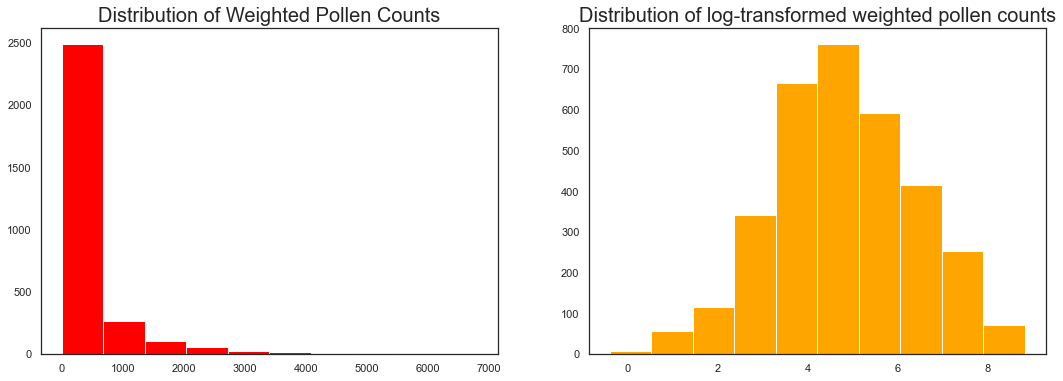

In [81]:
#plotting histograms of pre and post log-transofrmed data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax1.hist(log_df['pollen_weighted'], color='red')
ax1.set_title('Distribution of Weighted Pollen Counts', size=20)
ax2.hist(log_df['log_pollen'], color='orange')
ax2.set_title('Distribution of log-transformed weighted pollen counts', size=20);

Clearly, the log transformed fits a more normal distribution which appears to make sense as pollen count growth in nature is exponential at the start of allergy season

Text(0, 0.5, 'log-transformed pollen counts')

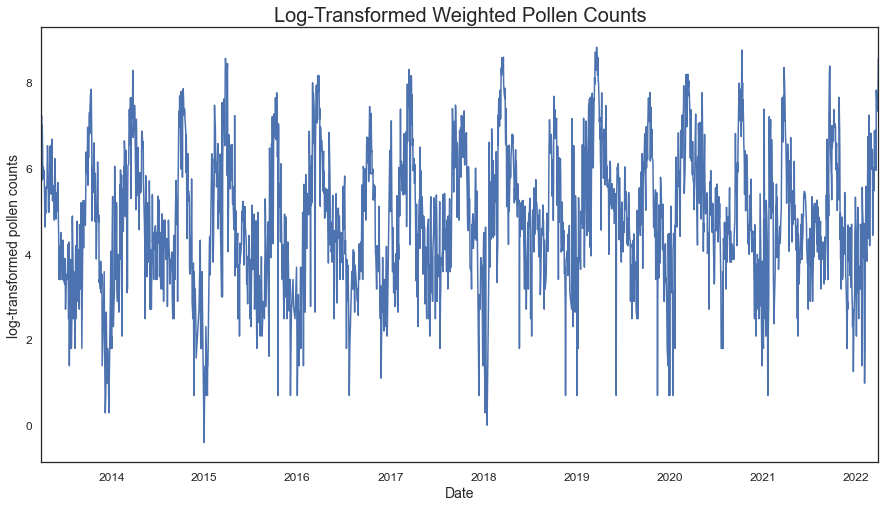

In [82]:
#visualizing the log-tranformed time series
ax = log_df['log_pollen'].plot(figsize=(15,8), fontsize=12)
ax.set_title("Log-Transformed Weighted Pollen Counts", size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('log-transformed pollen counts', size=14)

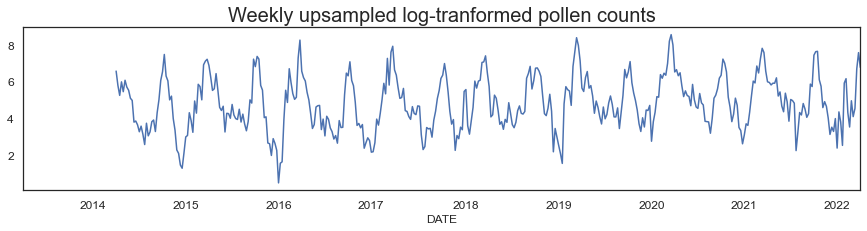

In [83]:
weekly_log = log_df.resample('W').mean()

#getting the data shifted forward 1 year (52 weeks)
shifted_weekly = weekly_log['log_pollen'].shift(52)
ax= shifted_weekly.plot(figsize=(15,3), fontsize=12)
ax.set_title('Weekly upsampled log-tranformed pollen counts', size=20);

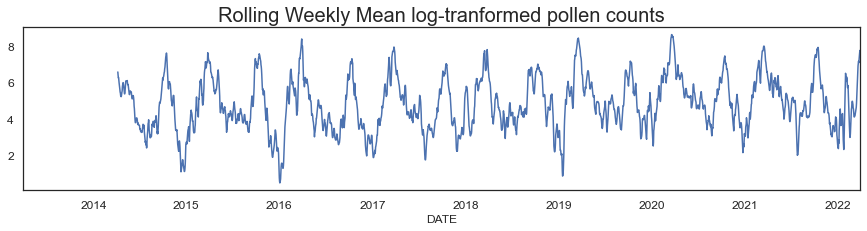

In [84]:
shifted_rolling = log_df['log_pollen'].rolling(7).mean().shift(365)
ax = shifted_rolling.plot(figsize=(15,3), fontsize=12)
ax.set_title('Rolling Weekly Mean log-tranformed pollen counts', size=20);

The upsampled plot shows a smoother line but otherwise looks the same as the rolling mean plotted data. To better understand the nature of this time series data, the autocorrelation and partial correlation are visualized below for analysis:

C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


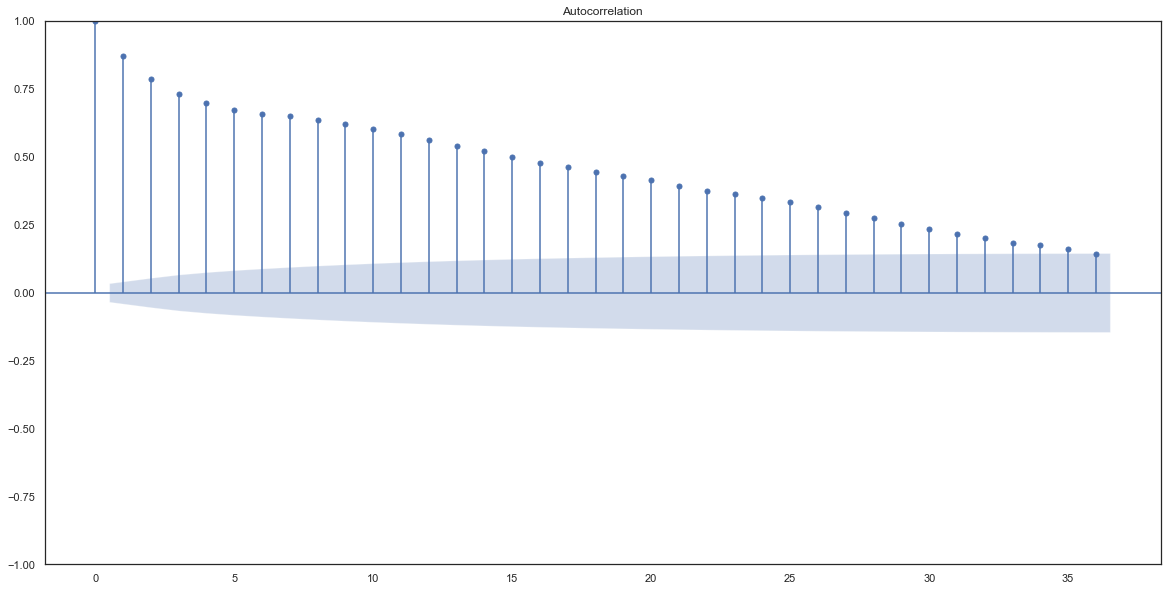

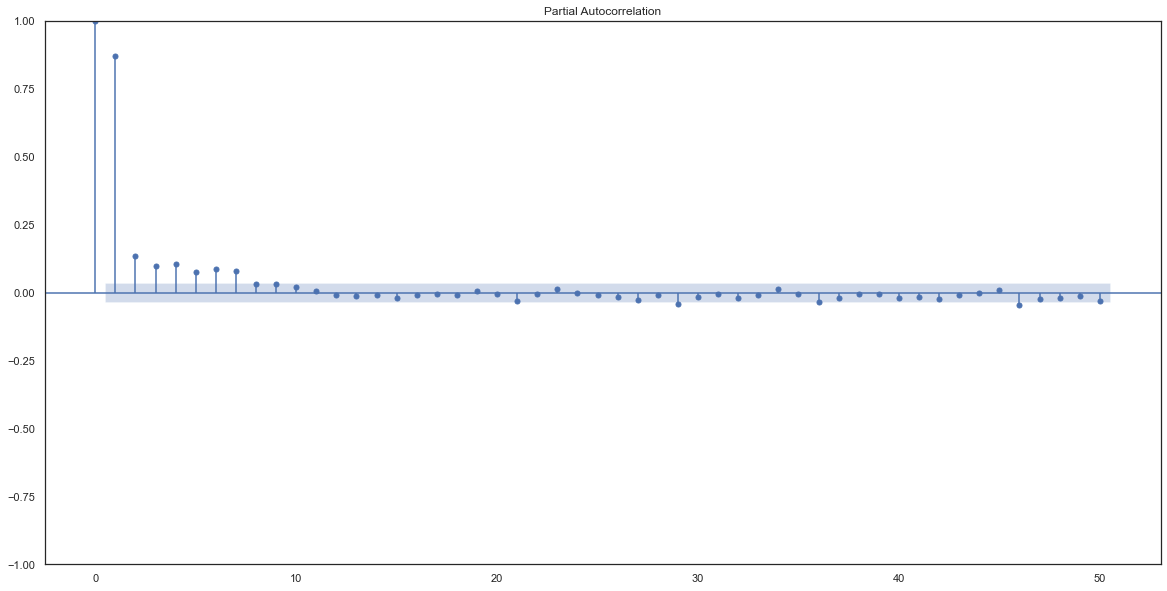

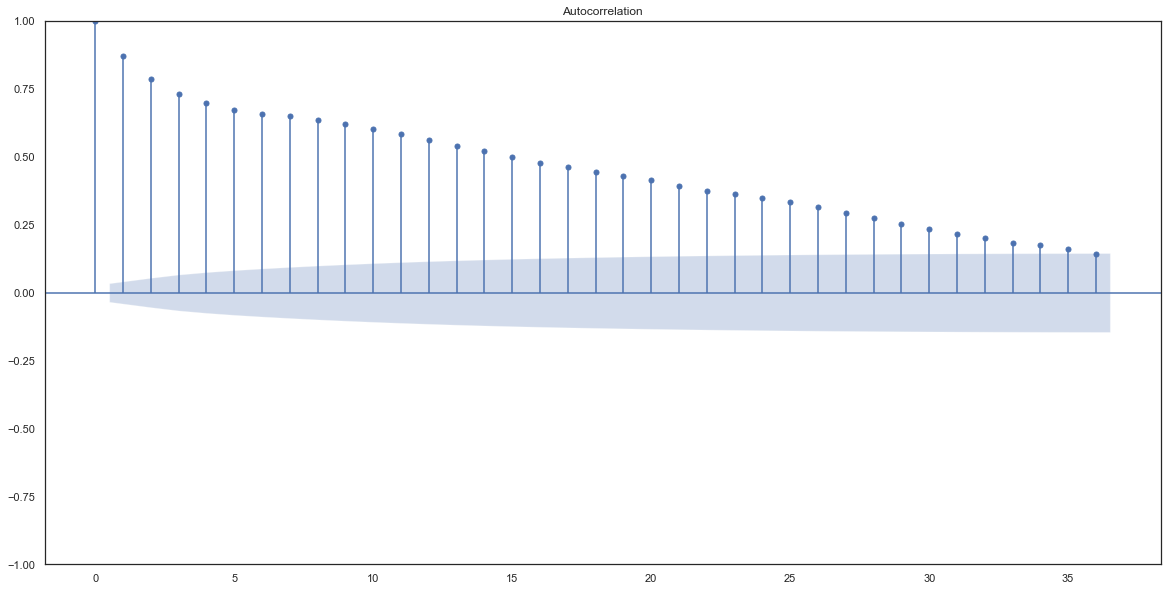

In [85]:
#functions for these plots 
plot_pacf(log_df['log_pollen'], lags = 50)
plot_acf(log_df['log_pollen'])

Given the above results, it looks like, from the autocorrelation, a MA term of 1 is probably ideal while for AR a 1 or 2 might be best. Arima/Sarima modeling the data must be split chronogically into Time Series Test/Train, splitting 80/20

In [86]:
#setting the cutoff index after 80 of data points
split_cutoff = round(len(log_df)*0.8)

Train = log_df[:split_cutoff]
Test = log_df[split_cutoff:]

Checking the stationarity of the time series and the weekly upsampled version:

In [87]:
print('P-value for dickey-fuller test on daily data:' ,adfuller(Train['log_pollen'])[1])
print('P-Value for dickey_fuller test on weekly data:', adfuller(Train['log_pollen'].resample('W').mean())[1])

P-value for dickey-fuller test on daily data: 3.491470815533315e-07
P-Value for dickey_fuller test on weekly data: 3.937576867166678e-12


both of the time series appear stationary given the small p-values
 
# Naive Baseline
For the time series modeling we will look at weekly data. The Naive baseline is just a 1 week forward shifted model

<AxesSubplot:xlabel='DATE'>

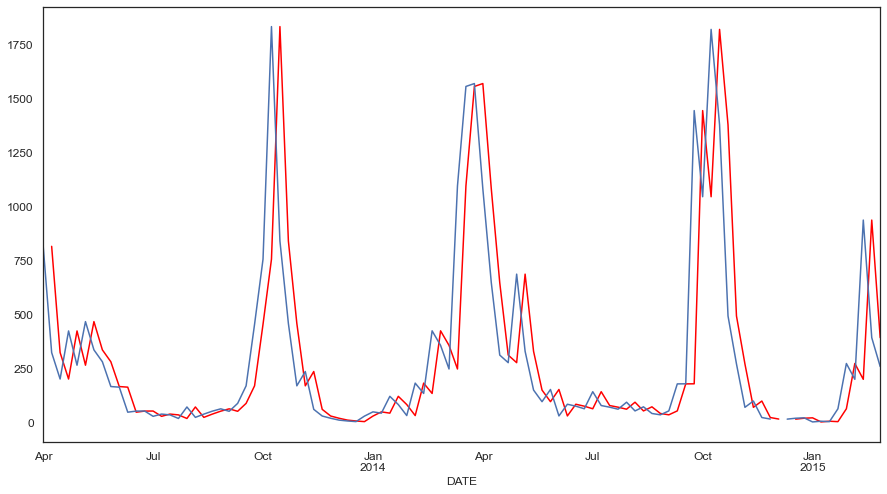

In [88]:
naive_baseline_raw = Train['pollen_weighted'].resample('W').mean().shift(1)

ax = naive_baseline_raw[:100].plot(figsize = (15,8), fontsize=12, color='red')
Train['pollen_weighted'].resample('W').mean()[:100].plot(color='b')

In [89]:
print('RMSE for naive model logged on training data:', 
      np.sqrt(mean_squared_error(Train['pollen_weighted'].resample('W').mean().bfill(), naive_baseline_raw.bfill())))

RMSE for naive model logged on training data: 479.35882885705735


With a RMSE of 479, this naive model is on average off the true pollen counts by that amount. This Naive model should do a farily good job at predicting because pollen remains in the air to some extent, so the previous week's counts will always influence the current day, in a manner somewhat simliar to a random walk model

<AxesSubplot:xlabel='DATE'>

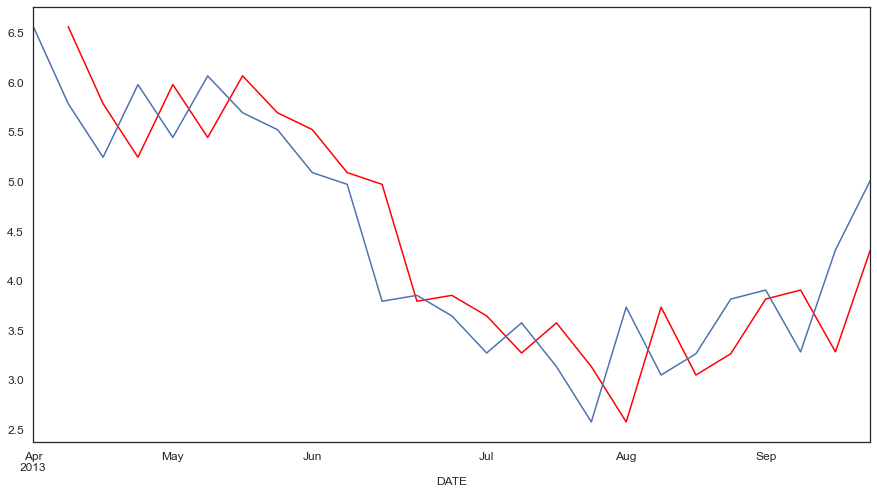

In [90]:
naive_baseline = Train['log_pollen'].resample('W').mean().shift(1)

ax = naive_baseline[:25].plot(figsize = (15,8), fontsize=12, color='red')
Train['log_pollen'].resample('W').mean()[:25].plot(color='b')

In [91]:
print('RMSE for naive model logged on training data:', np.sqrt(mean_squared_error(Train['log_pollen'].resample('W').mean(), 
                                                                          naive_baseline.bfill())))

RMSE for naive model logged on training data: 0.8068218276654914


This RMSE for the log-transformed data doesn't explain much intuitively, but can be used as a comparative metric

# 1-Year Shifted Rolling 7-Day Mean Model
for this first year-shifted model, the previous year's 7-day rolling mean was compared to the Test data. 

In [92]:
rolling_preds = shifted_rolling[Test.index[0]:Test.index[-1]]
shifted_weekly_preds = shifted_weekly[Test.index[0]:Test.index[-1]]
shifted_weekly_preds_train = shifted_weekly[Train.index[0]:Train.index[-1]]

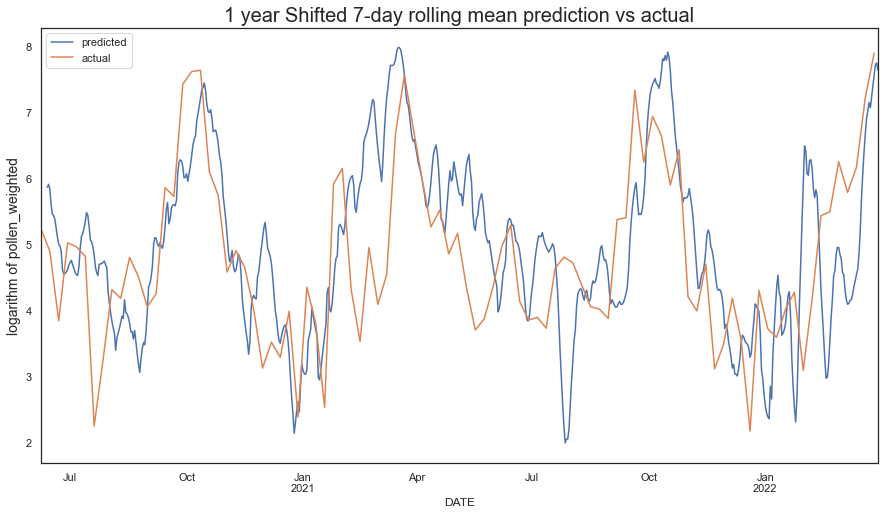

In [93]:
ax = rolling_preds.plot(figsize=(15,8))
Test['log_pollen'].resample('W').mean().plot()
ax.set_title('1 year Shifted 7-day rolling mean prediction vs actual', size=20)
ax.set_ylabel('logarithm of pollen_weighted', size=14);
ax.legend(['predicted', 'actual']);

checking the RMSE for the logged data doesn't give much tangible information but can help rate models comparatively. Then we exponentiate the log'd data to see how it compares to actual weighted pollen counts

In [94]:
# RSME of log transformed data: mostly just a point of comparison to other log-transformed models
np.sqrt(mean_squared_error(Test['log_pollen'].resample('W').mean(), rolling_preds.resample('W').mean()))

1.1359497398783782

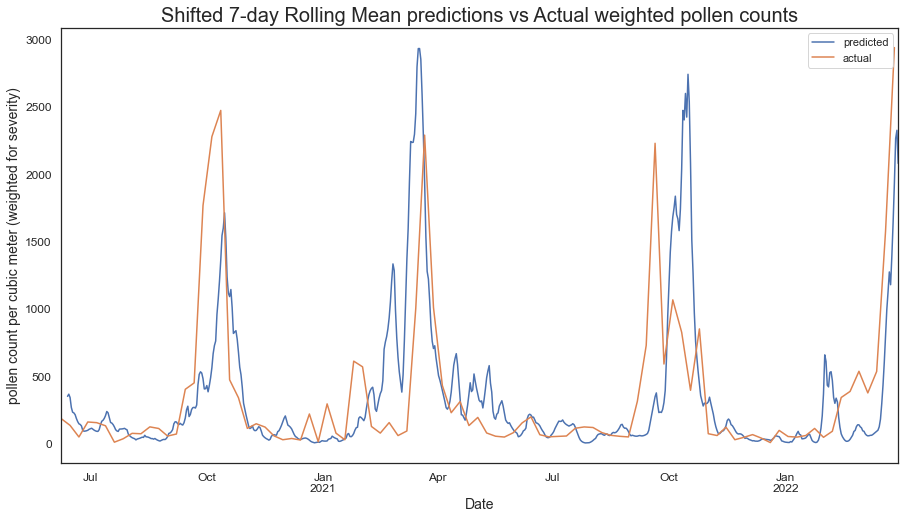

In [95]:
#plotting the shifted data vs. the actuals
ax = np.exp(rolling_preds).plot(figsize=(15,8), fontsize=12)
Test['pollen_weighted'].resample('W').mean().plot()
ax.set_title('Shifted 7-day Rolling Mean predictions vs Actual weighted pollen counts', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('pollen count per cubic meter (weighted for severity)', size=14)
ax.legend(['predicted', 'actual']);

In [96]:
print('RSME for year-shifted rolling mean model Exponentiated:',
      np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean()[:94], 
                                 np.exp(rolling_preds).resample('W').mean()[:94])))

RSME for year-shifted rolling mean model Exponentiated: 509.85527244000076


# 1-Year Shifted Weekly Model
simlar to above, the below model was validated on the previous years data. This was done for both log-transformed and re-exponentiated data

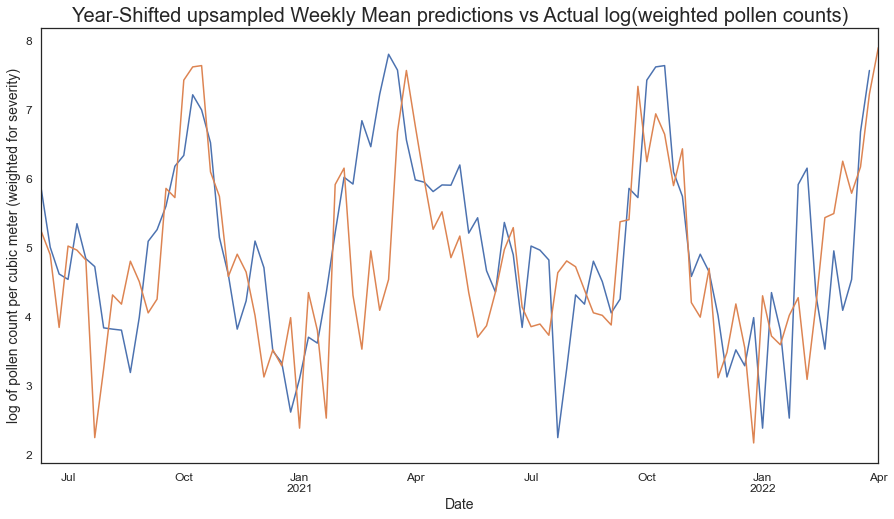

In [97]:
ax = shifted_weekly_preds.plot(figsize=(15,8), fontsize=12)
Test['log_pollen'].resample('W').mean().plot()
ax.set_title('Year-Shifted upsampled Weekly Mean predictions vs Actual log(weighted pollen counts)', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('log of pollen count per cubic meter (weighted for severity)', size=14);

In [98]:
# again look at this value to compare to previous model, only slightly lower here
np.sqrt(mean_squared_error(Test['log_pollen'].resample('W').mean()[:94], shifted_weekly_preds))

1.1698383186097705

Same as before, the log-transformed data is exponentiated and then compared to original weighted pollen counts below

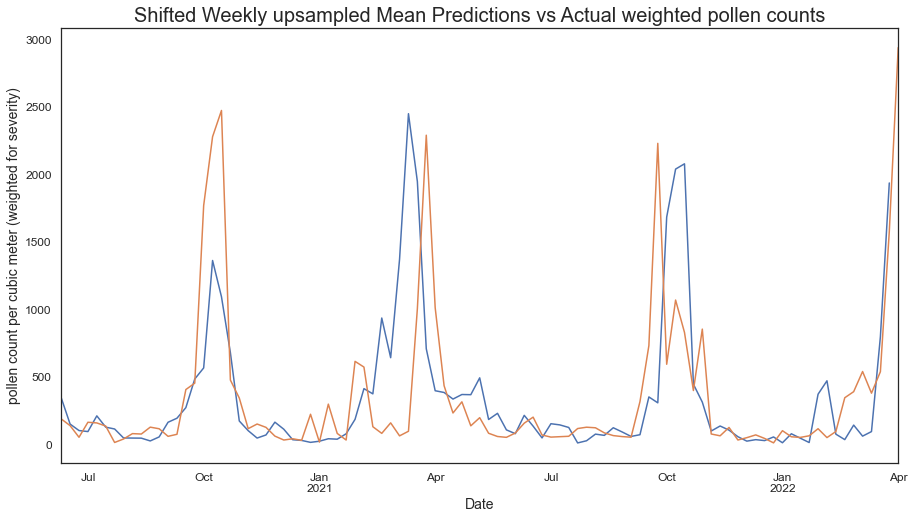

In [99]:
ax = np.exp(shifted_weekly_preds).plot(figsize=(15,8), fontsize=12)
Test['pollen_weighted'].resample('W').mean().plot()
ax.set_title('Shifted Weekly upsampled Mean Predictions vs Actual weighted pollen counts', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('pollen count per cubic meter (weighted for severity)', size=14);

In [100]:
print('Test RSME for year-shifted rolling mean model Exponentiated:',
      np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean()[:94], 
                                 np.exp(shifted_weekly_preds))))

Test RSME for year-shifted rolling mean model Exponentiated: 524.4390425033168


This shifted data produces less error  
# Year-shifted model on unstransformed data
this checks that the process of log-transforming and exponentiating performs about as well with the un-transformed pollen counts

In [101]:
shifted_pollen_preds = weekly_log['pollen_weighted'].shift(365)[Test.index[0]:Test.index[-1]]

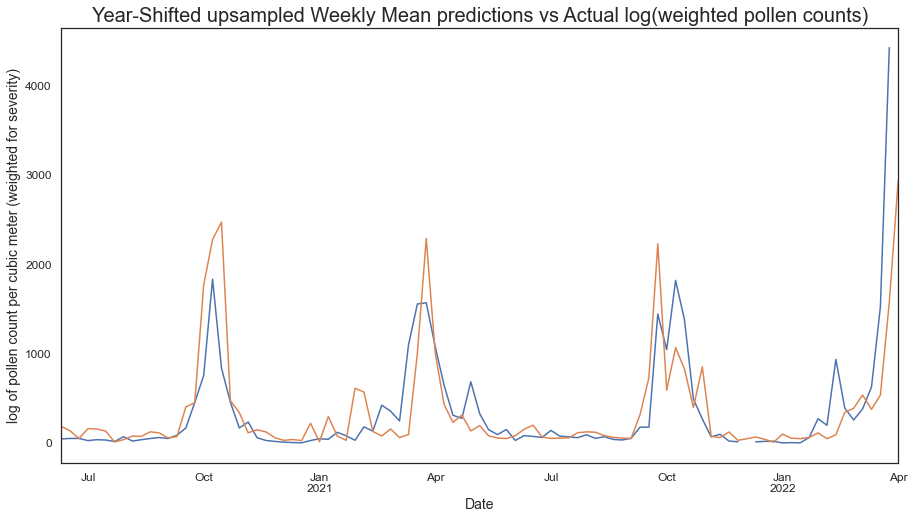

In [102]:
ax = shifted_pollen_preds.plot(figsize=(15,8), fontsize=12)
Test['pollen_weighted'].resample('W').mean().plot()
ax.set_title('Year-Shifted upsampled Weekly Mean predictions vs Actual log(weighted pollen counts)', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('log of pollen count per cubic meter (weighted for severity)', size=14);

In [103]:
print('RSME for year-shifted rolling mean model Exponentiated:',
      np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean()[:94], shifted_pollen_preds.interpolate())))

RSME for year-shifted rolling mean model Exponentiated: 455.48326253623173


This performs comparably to the model based of log-transformed pollen counts, providing evidence the the methodology is sound. 

# First Arima Model: log-transformed data
We'll use our AR and MA terms gleaned from plotting the ACF and PACF:

In [104]:
ARIMA_1 = sm.tsa.arima.ARIMA(Train['log_pollen'].resample('W').mean(), order=(2, 0, 1), seasonal_order=(0,1,1,52))
Arima_1_results = ARIMA_1.fit()

C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [105]:
Arima_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                       log_pollen   No. Observations:                  376
Model:             ARIMA(2, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -365.698
Date:                          Fri, 13 May 2022   AIC                            741.396
Time:                                  01:46:20   BIC                            760.300
Sample:                              04-07-2013   HQIC                           748.942
                                   - 06-14-2020                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0948      0.288     -0.330      0.742      -0.658       0.469
ar.L2          0.4033      0.147      2.743      0.006       0.115       0.692
ma.L1          0.6024      0.296      2.035      0.042       0.022       1.182
ma.S.L52      -0.9738      0.723     -1.347      0.178      -2.391       0.443
sigma2         0.4176      0.288      1.449      0.147      -0.147       0.983
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 9.26
Prob(Q):                              0.68   Prob(JB):                         0.01
Heteroskedasticity (H):               0.74   Skew:                             0.20
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
preds_arima_1 = Arima_1_results.predict(start=Test.resample('W').mean().index[0], end = Test.index[-1])
preds_train_arima1 = Arima_1_results.predict(start=Train.resample('W').mean().index[0], end = Train.resample('W').mean().index[-1])

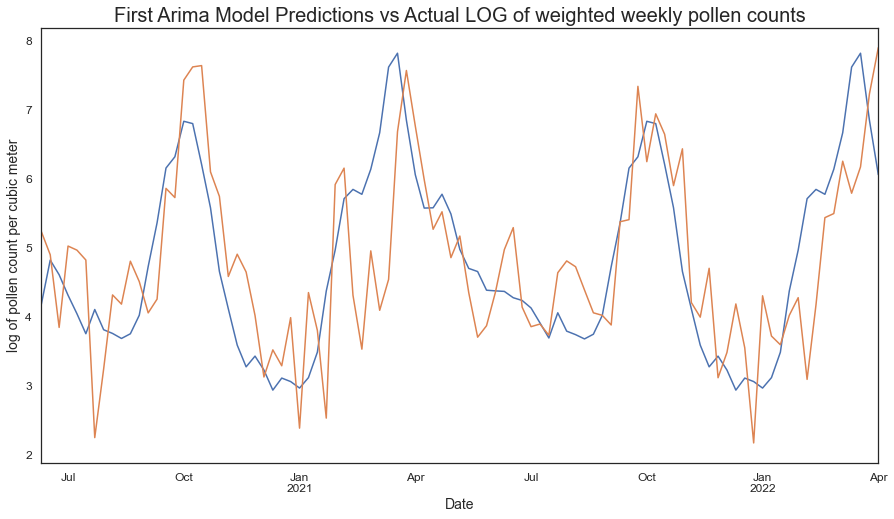

In [107]:
ax = preds_arima_1.plot(figsize=(15,8), fontsize=12, )
Test['log_pollen'].resample('W').mean().plot()
ax.set_title('First Arima Model Predictions vs Actual LOG of weighted weekly pollen counts', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('log of pollen count per cubic meter', size=14);

In [108]:
np.sqrt(mean_squared_error(Test['log_pollen'].resample('W').mean(), preds_arima_1))

1.0047890103705843

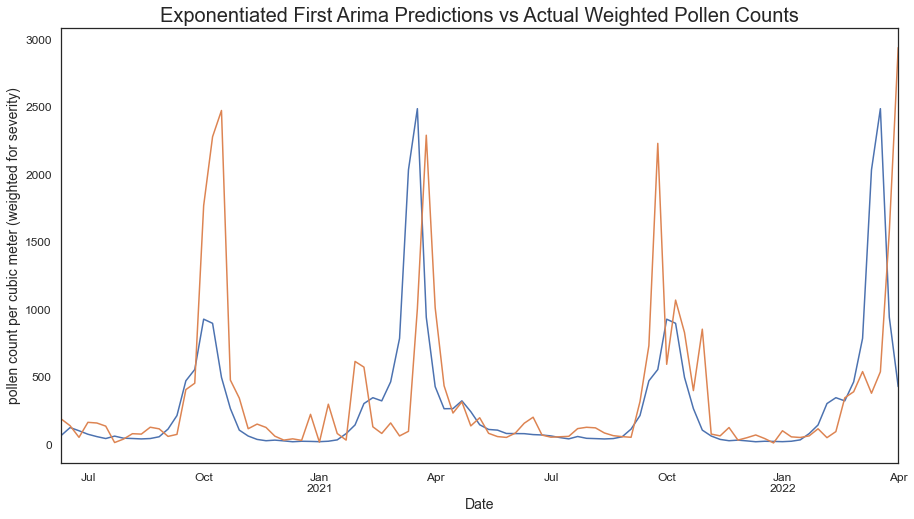

In [109]:
ax = np.exp(preds_arima_1).plot(figsize=(15,8), fontsize=12)
Test['pollen_weighted'].resample('W').mean().plot()
ax.set_title('Exponentiated First Arima Predictions vs Actual Weighted Pollen Counts', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('pollen count per cubic meter (weighted for severity)', size=14);

In [110]:
np.exp(preds_train_arima1).min()

1.0

In [111]:
print('Train RMSE:', np.sqrt(mean_squared_error(Train['pollen_weighted'].resample('W').mean().bfill(), 
                                                np.exp(preds_train_arima1.interpolate()))))
print('Test RMSE:', np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean(), 
                                               np.exp(preds_arima_1))))

Train RMSE: 410.9040275995172
Test RMSE: 591.9016031480883


This doesn't do any better than the year-shifted predictions, in fact it does worse in terms of error. Let's see how it fares for raw weighted pollen counts, data that has not been log-transformed. it also appears to be overfitting on the Train data
# Second Arima Model: Raw Weighted pollen counts

In [112]:
raw_arima = sm.tsa.arima.ARIMA(Train['pollen_weighted'].resample('W').mean(), order=(2, 0, 1), seasonal_order=(0,1,1,52))
raw_arima_results = raw_arima.fit()

C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [113]:
raw_arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                  pollen_weighted   No. Observations:                  376
Model:             ARIMA(2, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -2354.651
Date:                          Fri, 13 May 2022   AIC                           4719.302
Time:                                  01:46:45   BIC                           4738.206
Sample:                              04-07-2013   HQIC                          4726.847
                                   - 06-14-2020                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4426      0.044     33.019      0.000       1.357       1.528
ar.L2         -0.4438      0.039    -11.268      0.000      -0.521      -0.367
ma.L1         -0.9871      0.036    -27.058      0.000      -1.059      -0.916
ma.S.L52      -0.7959      0.039    -20.197      0.000      -0.873      -0.719
sigma2      1.073e+05   4433.749     24.200      0.000    9.86e+04    1.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):              3859.94
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             2.70
Prob(H) (two-sided):                  0.89   Kurtosis:                        19.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
raw_preds = raw_arima_results.predict(start=Test.resample('W').mean().index[0], end=Test.index[-1])

<AxesSubplot:xlabel='DATE'>

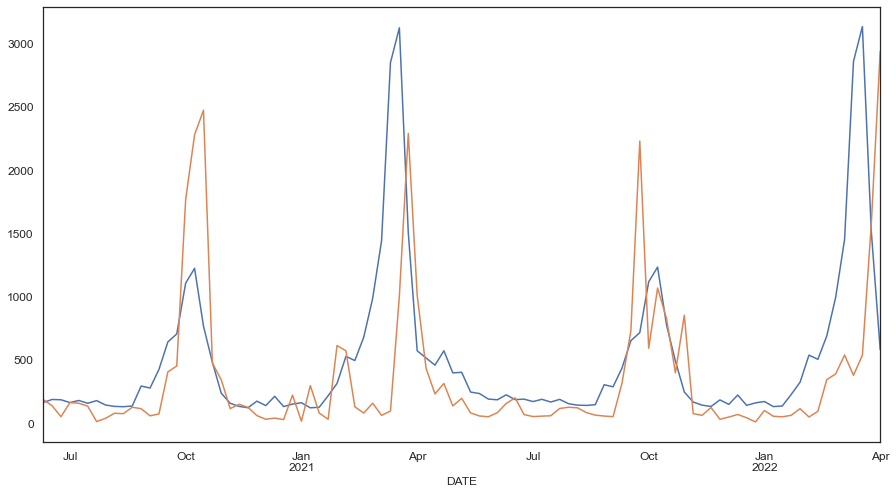

In [115]:
ax = raw_preds.plot(figsize=(15,8), fontsize=12)
Test['pollen_weighted'].resample('W').mean().plot()

In [116]:
print('RMSE for unlogged weekly model:', 
      np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean(), raw_preds)))

RMSE for unlogged weekly model: 688.1521009884573


From above the root-mean-squared-error for the log-transformed and re-exponentiated data smaller at 591, than the error of modeling based off of the raw weighted pollen counts at 688. Both of these are still larger than the error from the year-shifted predictions. 

# First Sarima Model
There is high seasonality that must be accounted for in the model. While a seasonal order was specified for the Arima model, a Sarima model should work as well if not better.

The first step is to iterate through the basic parameters p,d,q, to find a model with the lowet Aikake information criterion (AIC).

### Iterating over p, d, q to find best parameters.
given our PACF and ACF we choose to iterate the p, or AR term over 0,1,2 and the others over 0 & 1

In [117]:
# Defining the d and q parameters to take any value between 0 and 2 and p between 0 and 3
d = q = range(0, 2)
p=range(0,3)

# Generating all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generating all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [118]:
#iterating over the combination of values defined above
params_sarima = []
for combo in pdq:
    for combos in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX((Train['log_pollen'].resample('W').mean()),
                                            order=combo,
                                            seasonal_order=combos,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            params_sarima.append([combo, combos, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combo, combos, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 52)12 : AIC Calculated =2276.732204814876
ARIMA (0, 0, 0) x (0, 0, 1, 52)12 : AIC Calculated =1692.451069685558
ARIMA (0, 0, 0) x (0, 1, 0, 52)12 : AIC Calculated =919.4095177680795
ARIMA (0, 0, 0) x (0, 1, 1, 52)12 : AIC Calculated =685.066899660161
ARIMA (0, 0, 0) x (1, 0, 0, 52)12 : AIC Calculated =923.3201526454314
ARIMA (0, 0, 0) x (1, 0, 1, 52)12 : AIC Calculated =820.0015475179799
ARIMA (0, 0, 0) x (1, 1, 0, 52)12 : AIC Calculated =711.5736291996009
ARIMA (0, 0, 0) x (1, 1, 1, 52)12 : AIC Calculated =703.6242747804745


C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (2, 0, 0, 52)12 : AIC Calculated =711.0652493421478
ARIMA (0, 0, 0) x (2, 0, 1, 52)12 : AIC Calculated =695.4673158523789
ARIMA (0, 0, 0) x (2, 1, 0, 52)12 : AIC Calculated =570.2810394608339
ARIMA (0, 0, 0) x (2, 1, 1, 52)12 : AIC Calculated =571.7668515276007
ARIMA (0, 0, 1) x (0, 0, 0, 52)12 : AIC Calculated =1844.2538181926566
ARIMA (0, 0, 1) x (0, 0, 1, 52)12 : AIC Calculated =1405.732809981488
ARIMA (0, 0, 1) x (0, 1, 0, 52)12 : AIC Calculated =866.4579531284166
ARIMA (0, 0, 1) x (0, 1, 1, 52)12 : AIC Calculated =614.1655931788296
ARIMA (0, 0, 1) x (1, 0, 0, 52)12 : AIC Calculated =871.2961900035532
ARIMA (0, 0, 1) x (1, 0, 1, 52)12 : AIC Calculated =756.8674276806812
ARIMA (0, 0, 1) x (1, 1, 0, 52)12 : AIC Calculated =647.6399058236099
ARIMA (0, 0, 1) x (1, 1, 1, 52)12 : AIC Calculated =634.7882542381461
ARIMA (0, 0, 1) x (2, 0, 0, 52)12 : AIC Calculated =648.9577294802089


C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (2, 0, 1, 52)12 : AIC Calculated =654.0040233855916
ARIMA (0, 0, 1) x (2, 1, 0, 52)12 : AIC Calculated =513.2467608502186
ARIMA (0, 0, 1) x (2, 1, 1, 52)12 : AIC Calculated =515.2088996509959
ARIMA (0, 1, 0) x (0, 0, 0, 52)12 : AIC Calculated =903.8751524563728
ARIMA (0, 1, 0) x (0, 0, 1, 52)12 : AIC Calculated =775.5274605371347
ARIMA (0, 1, 0) x (0, 1, 0, 52)12 : AIC Calculated =954.7187402892393
ARIMA (0, 1, 0) x (0, 1, 1, 52)12 : AIC Calculated =639.7954129879058
ARIMA (0, 1, 0) x (1, 0, 0, 52)12 : AIC Calculated =778.2813323351197
ARIMA (0, 1, 0) x (1, 0, 1, 52)12 : AIC Calculated =777.5107960173091
ARIMA (0, 1, 0) x (1, 1, 0, 52)12 : AIC Calculated =700.8748360983939
ARIMA (0, 1, 0) x (1, 1, 1, 52)12 : AIC Calculated =675.37102672538
ARIMA (0, 1, 0) x (2, 0, 0, 52)12 : AIC Calculated =621.3131171854901
ARIMA (0, 1, 0) x (2, 0, 1, 52)12 : AIC Calculated =618.544110477029
ARIMA (0, 1, 0) x (2, 1, 0, 52)12 : AIC Calculated =542.3067987100702
ARIMA (0, 1, 0) x (2, 1

C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 0) x (0, 1, 0, 52)12 : AIC Calculated =925.2135594349859
ARIMA (1, 1, 0) x (0, 1, 1, 52)12 : AIC Calculated =626.6856421143347
ARIMA (1, 1, 0) x (1, 0, 0, 52)12 : AIC Calculated =775.748262207103
ARIMA (1, 1, 0) x (1, 0, 1, 52)12 : AIC Calculated =766.0830715252384
ARIMA (1, 1, 0) x (1, 1, 0, 52)12 : AIC Calculated =688.8356354733778
ARIMA (1, 1, 0) x (1, 1, 1, 52)12 : AIC Calculated =663.3556886195331
ARIMA (1, 1, 0) x (2, 0, 0, 52)12 : AIC Calculated =618.5057483023236
ARIMA (1, 1, 0) x (2, 0, 1, 52)12 : AIC Calculated =615.3853553249829
ARIMA (1, 1, 0) x (2, 1, 0, 52)12 : AIC Calculated =532.2100651119088
ARIMA (1, 1, 0) x (2, 1, 1, 52)12 : AIC Calculated =530.7237448025883
ARIMA (1, 1, 1) x (0, 0, 0, 52)12 : AIC Calculated =904.7892113769124
ARIMA (1, 1, 1) x (0, 0, 1, 52)12 : AIC Calculated =774.5468293859508
ARIMA (1, 1, 1) x (0, 1, 0, 52)12 : AIC Calculated =853.9593561947746
ARIMA (1, 1, 1) x (0, 1, 1, 52)12 : AIC Calculated =570.4666294620167
ARIMA (1, 1, 1) x (1,

C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 1, 1) x (1, 0, 1, 52)12 : AIC Calculated =768.1560803637483
ARIMA (1, 1, 1) x (1, 1, 0, 52)12 : AIC Calculated =628.8009808811937
ARIMA (1, 1, 1) x (1, 1, 1, 52)12 : AIC Calculated =604.1470028220061
ARIMA (1, 1, 1) x (2, 0, 0, 52)12 : AIC Calculated =620.5785385310274
ARIMA (1, 1, 1) x (2, 0, 1, 52)12 : AIC Calculated =617.7042781623289
ARIMA (1, 1, 1) x (2, 1, 0, 52)12 : AIC Calculated =485.19335423295365
ARIMA (1, 1, 1) x (2, 1, 1, 52)12 : AIC Calculated =482.75060209453756
ARIMA (2, 0, 0) x (0, 0, 0, 52)12 : AIC Calculated =905.3632063831462
ARIMA (2, 0, 0) x (0, 0, 1, 52)12 : AIC Calculated =777.6759773098673
ARIMA (2, 0, 0) x (0, 1, 0, 52)12 : AIC Calculated =852.2227386882358
ARIMA (2, 0, 0) x (0, 1, 1, 52)12 : AIC Calculated =584.9557182096601
ARIMA (2, 0, 0) x (1, 0, 0, 52)12 : AIC Calculated =774.807533016773
ARIMA (2, 0, 0) x (1, 0, 1, 52)12 : AIC Calculated =735.680794314362
ARIMA (2, 0, 0) x (1, 1, 0, 52)12 : AIC Calculated =628.255507308359
ARIMA (2, 0, 0) x (1,

C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (1, 0, 1, 52)12 : AIC Calculated =838.086008944409


C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (1, 1, 0, 52)12 : AIC Calculated =630.4747879461213


C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (1, 1, 1, 52)12 : AIC Calculated =613.276720762283


C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 0, 0, 52)12 : AIC Calculated =619.9491532635582


C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 0, 1, 52)12 : AIC Calculated =668.2160855484965


C:\Users\Nick\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (2, 0, 1) x (2, 1, 0, 52)12 : AIC Calculated =491.4586020975345
ARIMA (2, 0, 1) x (2, 1, 1, 52)12 : AIC Calculated =492.4758961457665
ARIMA (2, 1, 0) x (0, 0, 0, 52)12 : AIC Calculated =904.2696091932363
ARIMA (2, 1, 0) x (0, 0, 1, 52)12 : AIC Calculated =778.184267236008
ARIMA (2, 1, 0) x (0, 1, 0, 52)12 : AIC Calculated =920.3525629255955
ARIMA (2, 1, 0) x (0, 1, 1, 52)12 : AIC Calculated =624.0223128574652
ARIMA (2, 1, 0) x (1, 0, 0, 52)12 : AIC Calculated =775.6778931716327
ARIMA (2, 1, 0) x (1, 0, 1, 52)12 : AIC Calculated =763.0047307711867
ARIMA (2, 1, 0) x (1, 1, 0, 52)12 : AIC Calculated =680.9643770587306
ARIMA (2, 1, 0) x (1, 1, 1, 52)12 : AIC Calculated =656.7485133770595
ARIMA (2, 1, 0) x (2, 0, 0, 52)12 : AIC Calculated =617.6052657211984
ARIMA (2, 1, 0) x (2, 0, 1, 52)12 : AIC Calculated =613.7069009425982
ARIMA (2, 1, 0) x (2, 1, 0, 52)12 : AIC Calculated =525.6064036099622
ARIMA (2, 1, 0) x (2, 1, 1, 52)12 : AIC Calculated =524.7731724154248
ARIMA (2, 1, 1) x (0,

In [119]:
# Find the parameters with minimum AIC value from the above's iterations
params_sarima_df = pd.DataFrame(params_sarima, columns=['pdq', 'pdqs', 'aic'])
params_sarima_df.loc[params_sarima_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (2, 1, 1, 52)
aic           482.751
Name: 95, dtype: object

### Plugging the parameters into the model:

In [120]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_1 = sm.tsa.statespace.SARIMAX(Train['log_pollen'].resample('W').mean(), 
                                        order=(1, 1, 1), 
                                        seasonal_order=(2, 1, 1, 52), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output_sarima = sarima_1.fit()
output_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         log_pollen   No. Observations:                  376
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 52)   Log Likelihood                -235.375
Date:                            Fri, 13 May 2022   AIC                            482.751
Time:                                    02:03:20   BIC                            503.058
Sample:                                04-07-2013   HQIC                           490.953
                                     - 06-14-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4656      0.052      8.988      0.000       0.364       0.567
ma.L1         -1.0000     47.756     -0.021      0.983     -94.599      92.599
ar.S.L52      -0.3881      0.099     -3.927      0.000      -0.582      -0.194
ar.S.L104     -0.2811      0.067     -4.226      0.000      -0.412      -0.151
ma.S.L52      -0.4002      0.129     -3.105      0.002      -0.653      -0.148
sigma2         0.4766     22.755      0.021      0.983     -44.122      45.076
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.87   Prob(JB):                         0.16
Heteroskedasticity (H):               0.57   Skew:                             0.12
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The first Sarima Model appears to have potentially insignificant terms in the seasonal order based off p-values. We then check the diagnostics to verify assumptions:

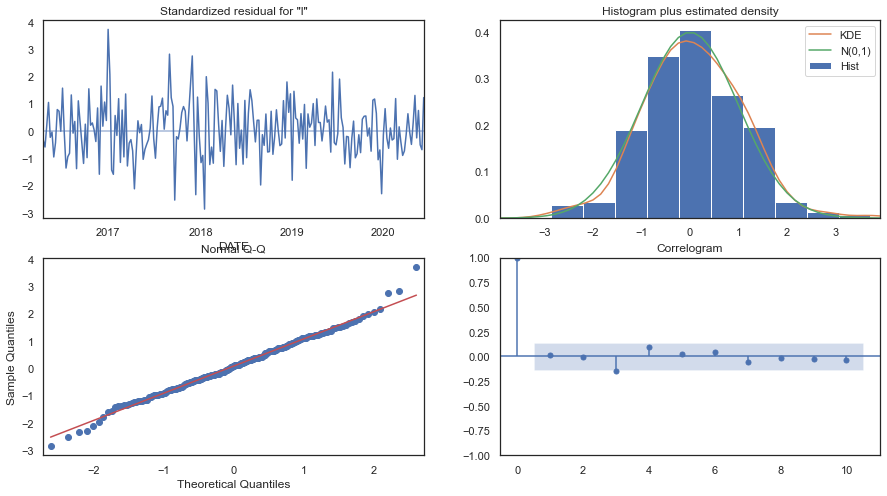

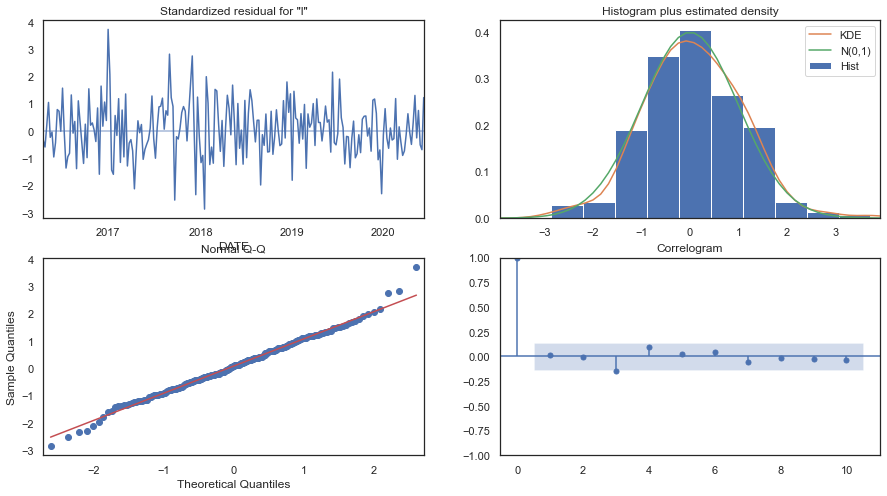

In [121]:
output_sarima.plot_diagnostics(figsize=(15,8))

Now to compare predictions to real test values:

In [122]:
#test and train data predictions from the sarima madel
preds_sarima_test = output_sarima.predict(start=Test.resample('W').mean().index[0], end = Test.index[-1])
preds_sarima_train =  output_sarima.predict(start=Train.resample('W').mean().index[0], 
                                            end = Train.resample('W').mean().index[-1])

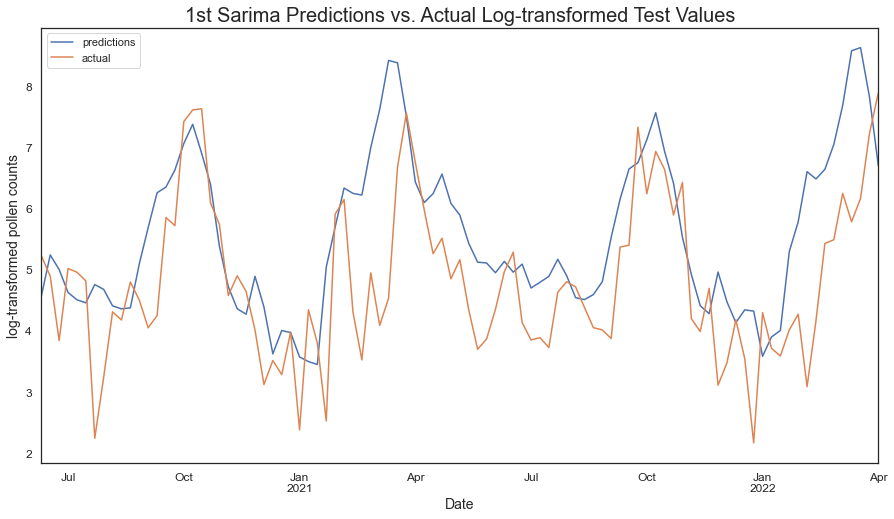

In [123]:
#plotting predictions of Sarima model vs actual log transformed values
ax = preds_sarima_test.plot(figsize=(15,8), fontsize=12)
Test['log_pollen'].resample('W').mean().plot()
ax.legend(['predictions', 'actual'])
ax.set_title('1st Sarima Predictions vs. Actual Log-transformed Test Values', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('log-transformed pollen counts', size=14);

In [124]:
# taking the RMSE of the log transformed data to compare to prior models
np.sqrt(mean_squared_error(Test['log_pollen'].resample('W').mean(), preds))

NameError: name 'preds' is not defined

Well the log transformed RSME 

In [ ]:
ax = np.exp(preds_sarima_test).plot(figsize=(15,8), fontsize=12)
Test.resample('W').mean()['pollen_weighted'].plot()
ax.legend(['predictions', 'actual'])
ax.set_title('1st Sarima Predictions vs. Actual Weighted Pollen Count Test Values', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('weighted pollen counts per cubic meter', size=14);

In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(Train['pollen_weighted'].resample('W').mean().interpolate()
                                                , np.exp(preds_sarima_train))))

In [ ]:

print('Test RMSE:', np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean()
                                               , np.exp(preds_sarima_test))))

This is much higher error on both train and test in terms of RMSE than the first 2 Arima models, despite the lower AIC. Below we'll use the Sarimax module to iterate over the parameters

# Second Sarima Model 
Given the much greater error on the first Sarima model than all previous models, we try one last attempt, this time only considering one AR term this time. 

In [ ]:
# Defining the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)


# Generating all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generating all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
#Like before this code iterates over the potential values of p, d, and q (1 or 0)
params_sarima_2 = []
for combo in pdq:
    for combos in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX((Train['log_pollen'].resample('W').mean()),
                                            order=combo,
                                            seasonal_order=combos,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output_sarima_2 = mod.fit()
            params_sarima_2.append([combo, combos, output_sarima_2.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combo, combos, output_sarima_2.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
params_sarima2_df = pd.DataFrame(params_sarima_2, columns=['pdq', 'pdqs', 'aic'])
params_sarima2_df.loc[params_sarima2_df['aic'].idxmin()]

having found the paramaters again that yield the lowest AIC of the group, they are plugged in below:

In [ ]:
sarima_2 = sm.tsa.statespace.SARIMAX(Train.resample('W').mean()['log_pollen'], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 52), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output_sarima_2 = sarima_2.fit()
output_sarima_2.summary()

In [ ]:
preds_sarima2_test = output_sarima_2.predict(start = Test['log_pollen'].resample('W').mean().index[0], 
                                             end = Test['log_pollen'].index[-1])
preds_sarima2_train = output_sarima_2.predict(start = Train['log_pollen'].resample('W').mean().index[0], 
                                             end = Train['log_pollen'].resample('W').mean().index[-1])

In [ ]:
#plotting predictions of Sarima model vs actual log transformed values
ax = preds_sarima2_test.plot(figsize=(15,8), fontsize=12)
Test['log_pollen'].resample('W').mean().plot()
ax.legend(['predictions', 'actual'])
ax.set_title('2nd Sarima Predictions vs. Actual Log-transformed Test Values', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('log-transformed pollen counts', size=14);

In [ ]:
# taking the RMSE of the log transformed data to compare to prior models
np.sqrt(mean_squared_error(Test['log_pollen'].resample('W').mean(), preds_sarima2_test))

Again the predictions are exponentiated and compared to the actual weighted pollen counts. 

In [ ]:
#plotting exponentiated predictions against actual weighted pollen counts
ax = np.exp(preds_sarima2_test).plot(figsize=(15,8), fontsize=12)
Test.resample('W').mean()['pollen_weighted'].plot()
ax.legend(['predictions', 'actual'])
ax.set_title('2nd Sarima Predictions vs. Actual Weighted Pollen Count Test Values', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('weighted pollen counts per cubic meter', size=14);

In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(Train['pollen_weighted'].resample('W').mean().interpolate()
                                                , np.exp(preds_sarima2_train))))
print('Test RMSE:', np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean()
                                               , np.exp(preds_sarima2_test))))

surprisingly, despite the lower AIC for the first Sarima model, the second , with only 1 AR term, appears to perfrom better on both the train and test data in terms of error. The next two sets of model parameters with the 2nd and 3rd lowest AIC actually perform much better in terms of RMSE. Additionally this model appears to be underfitting as opposed to overfitting:
# Third Sarima Model
in the third sarima model we try the third best model in terms of AIC from the previous section

In [ ]:
sarima_3 = sm.tsa.statespace.SARIMAX(Train.resample('W').mean()['log_pollen'], 
                                        order=(1, 0, 1), 
                                        seasonal_order=(0, 1, 1, 52), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output_sarima_3 = sarima_3.fit()
output_sarima_3.summary()

Both log likelihood and AIC for this model suggest poorer fits on training data than the 2nd Sarima. The comparison for just the exponentiated predicitons is shown below

In [ ]:
#Getting this 3rd Sarima model's predictions
preds_sarima3_test = output_sarima_3.predict(start = Test.resample('W').mean().index[0], end = Test.index[-1])
preds_sarima3_train = output_sarima_3.predict(start = Train['log_pollen'].resample('W').mean().index[0], 
                                             end = Train['log_pollen'].resample('W').mean().index[-1])

In [ ]:


#plotting exponentiated predictions against actual weighted pollen counts
ax = np.exp(preds_sarima3_test).plot(figsize=(15,8), fontsize=12)
Test.resample('W').mean()['pollen_weighted'].plot()
ax.legend(['predictions', 'actual'])
ax.set_title('2nd Sarima Predictions vs. Actual Weighted Pollen Count Test Values', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('weighted pollen counts per cubic meter', size=14);

In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(Train['pollen_weighted'].resample('W').mean().interpolate()
                                                , np.exp(preds_sarima3_train))))
print('Test RMSE:', np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean()
                                               , np.exp(preds_sarima3_test))))

In terms of RMSE, this third model outperforms all of the other Sarima models in the section except the first which used statsmodels' ARIMA module instead of SARIMAX

In [ ]:
output_sarima_3.plot_diagnostics(figsize = (15,8))

again we see the assumptions for time series modeling mostly satisfied for the log-transformed data. 

# Sarima Modeling raw pollen counts
earlier we saw with the first Arima/Sarima model that modeling the log=transformed data produced a better fit when re-exponentiated. Below we try again iterating over p, d and q as before but fitting to raw weighted pollen counts this time

In [ ]:
#Like before this code iterates over the potential values of p, d, and q (1 or 0)
params_sarima_raw = []
for combo in pdq:
    for combos in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX((Train['pollen_weighted'].resample('W').mean()),
                                            order=combo,
                                            seasonal_order=combos,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output_sarima_raw = mod.fit()
            params_sarima_raw.append([combo, combos, output_sarima_raw.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(combo, combos, output_sarima_raw.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
params_sarimaraw_df = pd.DataFrame(params_sarima_raw, columns=['pdq', 'pdqs', 'aic'])
params_sarimaraw_df.loc[params_sarimaraw_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_raw = sm.tsa.statespace.SARIMAX(Train.resample('W').mean()['pollen_weighted'], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 52), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output_sarima_raw = sarima_raw.fit()
output_sarima_raw.summary()

In [ ]:
output_sarima_raw.plot_diagnostics(figsize= (15,18))

Again the residuals don't appear to be evenly distributed for the model based of un-transformed data. Below we visualize and examine the error:

In [ ]:
preds_sarima_raw_test = output_sarima_raw.predict(start= Test.resample('W').mean().index[0], 
                                                  end= Test.resample('W').mean().index[-1])
preds_sarima_raw_train = output_sarima_raw.predict(start= Train.resample('W').mean().index[0], 
                                                  end= Train.resample('W').mean().index[-1])

In [ ]:
#plotting pollen count predictions against actual weighted pollen counts
ax = preds_sarima_raw_test.plot(figsize=(15,8), fontsize=12)
Test.resample('W').mean()['pollen_weighted'].plot()
ax.legend(['predictions', 'actual'])
ax.set_title('Sarima Raw Pollen Count Predictions vs. Actual Weighted Pollen Count Test Values', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('weighted pollen counts per cubic meter', size=14);

In [ ]:
print('Train RMSE:', np.sqrt(mean_squared_error(Train['pollen_weighted'].resample('W').mean().interpolate()
                                                , preds_sarima_raw_train)))
print('Test RMSE:', np.sqrt(mean_squared_error(Test['pollen_weighted'].resample('W').mean()
                                               , preds_sarima_raw_test)))

This model based off of the un-log-transformed weighted pollen counts appears to be overfitting given the much lower RMSE for the training data. In terms of Root-mean-squared-error, RMSE, however, the predictions with the lowest error are from the year_shifted model, with a RMSE of 425.

# 7) Further Considerations
## A. Species Analysis
An Additional goal of this report, intended primarily for further research is a comprehensive breakdown of plant (and eventually mold) species. The goal being to work with pharmacies and customers to match days of purchase and usage of allergy medications to spikes in pollen counts. This could be used a diagnostic support tool for allergy-type identification. 

In [ ]:
species_df = master_df[master_df.columns[:20]]
species_df['tree_total'] = master_df['Tree Total']
species_df['weed_total'] = master_df['Weed Total']
species_df['grass_total'] = master_df['Grass Total']
species_df.info()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.plot(species_df.resample('Q').mean().drop(columns=['weed_total', 'grass_total', 'tree_total']))
ax.legend(labels = species_df.columns)
ax.set_title('Quarterly Species-Specific Pollen Counts', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('Pollen Counts per Cubic Meter');

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.plot(species_df.resample('Q').mean()[['weed_total', 'grass_total', 'tree_total']])
ax.legend(['weed_total', 'grass_total', 'tree_total'])
ax.set_title('Quarterly Plant-Type Pollen Counts', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('Pollen Counts per Cubic Meter');

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(species_df.resample('W').mean()['2021'].drop(columns=['weed_total', 'grass_total', 'tree_total']))
ax.legend(labels = species_df.columns)
ax.set_title('Weekly Species-Specific Pollen Counts in 2021', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('Pollen Counts per Cubic Meter');

In [ ]:
#Tree Pollen by Species
ax = master_df.resample('Q').sum()[list(master_df.columns)[:15]].plot(fontsize=12, figsize=(15,8))
ax.set_title('Quarterly Tree Pollen Counts by Species', size=20)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('Pollen Count per Cubic Meter', size=14);

Data for allergy purposes is primarily available to research institutions via an application, however random data could be generated to be distributed more frequently around days of high pollen counts. These artificial consumer purchases throughout the decade could be matched by date to species-specific pollen counts to be used as a diagnostic tool. Many people do not have easy access to allergists, often due to financial constraints or scarcity of providers. Offering an alternative that aids the public in understanding the causes of their symptoms can empower individuals to take control of and learn about their allergies. This would potentially mitigate the upswing in doctor visits that occurs in allergy season, providing relief to over-extended medical facilities during the Covid-19 era.

Future work will provide the framework for an easy to use app that let's the public match their medication purchases to species' pollen counts and help them better understand the causes of their allergies and prepare to address their symptoms

## B. Improving Modeling

Pollen counts are the result of complex floral and atmospheric conditions not only locally but around the country. Pollen can remain in still air for up to 11 hours. Wind patterns make it so pollen can travel as much as 400 miles, decreasing logarithmically with distance. Other factors such humidity and species-specific growing conditions can also play a large role. Including more variables and incorporating the time-series element (seasonality) will only improve the model's accuracy. Adding climate data from more locations in and around Houston and using Principle Component Analysis (PCA) to reduce dimensionality and multicolinearity are also proposed and next steps.

## C. Investigating Mold Spore Counts
Pollen is only one cause of seasonal allergies. The Houston Health Department also has species-specific airborne mold spore counts which can be modeled like pollen and used to create a more robust classification of bad allergy days. 

## D. Improving High Pollen Criteria and incorporating multiple classes of severity
By refining the pollen count determination of `high` vs not high pollen days as well as modeling days of `very_high` and `super_high` pollen days would allow for better understanding of the effects and timing of allergies in the general public

# 8 Conclusion
Modeling a complex natural phenomenon like airborne pollen counts depends on a number of factors outside of basic local climate data like average temperature, average wind speed, and precipitation. While it's possible that these variables do indeed influcence daily pollen counts locally, it's also more than likely that it is their own seasonal patterns that allow for accurate modeling. Divorcing these variables and pollen counts from their seasonal components may not provide much insight into allergy severity. 

Due to the high levels of multicolinearity and seasonality of all of the data, Classifiers than ignore multicolinearity proved the most successful, with a K-Nearest-Neighbors model marginally outperforming the Random Forest Classifier model for best fit. 

Time Series modeling was possible for upsampled weekly data. It offered an accurate prediction of pollen counts as long as seasonality was incorporated. Log-transofrmed pollen counts produced better modeling results in terms of error. Different metrics of AIC and RMSE were not always consistent, with low-value AIC models sometimes resulting in higher RMSE. Out of the S/ARIMA type models, the first Arima model with an p,d,q order of (2,0,1) and seasonal order (0,1,1,52) performed best on the test data.  However, the best fit for test data predictions actually came from the previous year's counts, which predicted the test data with the least amount of error

Given the similarity in symptoms, bringing awareness and understanding to allergies is especially important in the post-Covid era as healthcare systems were taxed to their breaking points. Helping the public better understand the timing and causes of their sniffles and sneezes not only helps individuals, but also the medical providers that treat them.

# 9) References

1) https://www.chpa.org/sites/default/files/media/docs/2020-10/Assessing-Consumer-Benefits-of-Allergy-Rx-OTC-Switches-03012017.pdf

2) https://www.ochsner.org/services/allergy-asthma-and-immunology/pollen-mold







# 10) Appendix